# Predicting Student Residency Status: Comprehensive Analysis

## Research Question
**Can we predict whether a student lives on-campus or off-campus based on their shopping and package delivery behaviors?**

---

## Table of Contents
1. [Data Loading and Initial Exploration](#section1)
2. [Data Cleaning and Preprocessing](#section2)
3. [Exploratory Data Analysis (EDA)](#section3)
4. [Feature Relationships and Correlation](#section4)
5. [Multicollinearity Analysis (VIF)](#section5)
6. [Principal Component Analysis (PCA)](#section6)
7. [Hypothesis Testing](#section7)
8. [Logistic Regression - Assumptions and Modeling](#section8)
9. [Random Forest Modeling](#section9)
10. [Model Comparison and Conclusions](#section10)

---
## 1. Data Loading and Initial Exploration <a id='section1'></a>

In [46]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Statistics
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu, ttest_ind

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve
)

# Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


In [47]:
# Load raw data
data_raw = pd.read_csv("data.csv")

print("Dataset Shape:", data_raw.shape)
print("\nFirst few rows:")
data_raw.head()

Dataset Shape: (197, 19)

First few rows:


,Timestamp,Are you a current UCSD student or staff member?,Do you live on-campus or off-campus?,"What do you use as your PRIMARY access for delivery/shipping of packages? (if you use two or more sources equally, please select each one)",How many packages/online orders do you have delivered to campus in a typical week?,How many items are usually included in each package/online order you have delivered to campus?,How do you dispose of cardboard from packages you have delivered to campus?,"How do you dispose of plastic (bags, bubble wrap, etc.) from packages you have delivered to campus?",Please select the item types that you have delivered to campus,Which item category/categories in the question above do you have delivered to campus MOST? (you may also specify items purchased/gifted to you),"Are there any peak times during the academic year that you order more/less items to be delivered to campus (e.g. move-in, quarter beginning/end, holidays, etc.)? \nIf yes, please describe what time and if the item types you order change, too.",Please select the options(s) that best describe why you order packages to be delivered to campus instead of shopping in-store:,Please select the item categories that you buy in-stores,Which item category/categories in the question above do you buy in-stores MOST? (you may also specify items purchased),Do you typically buy from on or off-campus stores?,Would you be interested in any of the following shopping options being made more available/frequent? (especially to reduce online ordering),"Are there any items/goods that you would like the on-campus stores/vendors to offer? \n(identifying specific items, times they should be offered, and preferred price range is encouraged)",What communication method(s) do you get most of your campus news from?,Is there anything else you would like us to know?
0,2/12/2025 8:43:38,Undergraduate,I live on-campus,Mesa Nueva/The Trove/other on-campus parcel of...,<1,1,Toss in recycle bin,Toss in recycle bin,"Electronics (e.g. tablet, headphones, etc.)",Electronics,NaN,Transportation issues (ex. limited/no access t...,"Personal Care Goods (e.g. toothpaste, deodoran...",Food/Groceries,I buy from more off-campus stores,"Bulk goods options (e.g. groceries, household ...",NaN,Instagram/Social Media,NaN
1,2/12/2025 8:45:31,Undergraduate,I live off-campus (more than 5 miles away),Delivery/shipping directly to/from my home add...,I have never ordered an item to be delivered t...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Personal Care Goods (e.g. toothpaste, deodoran...","food/groceries, clothing",I buy from more off-campus stores,"Bulk goods options (e.g. groceries, household ...",Vegan snack/food options (less than $5),"Word-of-mouth, Email Newsletter/Announcements,...",NaN
2,2/12/2025 8:46:24,Undergraduate,I live on-campus,Amazon Lockers,<1,1,Toss in recycle bin,Toss in trash/garbage can,"Dormitory Goods (e.g. decor, cups/plates, etc....",Dormitory Goods,Move-In: mostly decor and items that get broken.,Transportation issues (ex. limited/no access t...,"Personal Care Goods (e.g. toothpaste, deodoran...",Personal Goods,I buy about the same amount from on- and off-c...,"Bulk goods options (e.g. groceries, household ...",NaN,"Word-of-mouth, Email Newsletter/Announcements,...",NaN
3,2/12/2025 8:49:22,Undergraduate,I live off-campus (within 5 miles),"Off-campus post offices, Delivery/shipping dir...",<1,1,Toss in recycle bin,Toss in trash/garbage can,"Dormitory Goods (e.g. decor, cups/plates, etc....",Dorm Essentials,NaN,Transportation issues (ex. limited/no access t...,"Personal Care Goods (e.g. toothpaste, deodoran...",Food,I buy from more off-campus stores,"Bulk goods options (e.g. groceries, household ...",Cheaper things larger quantities,"Word-of-mouth, Email Newsletter/Announcements,...",NaN
4,2/14/2025 9:57:31,Undergraduate,I live off-campus (within 5 miles),Delivery/shipping directly to/from my home add...,<1,2,Toss in recycle bin,Toss in trash/garbage can,"Dormitory Goods (e.g. decor, cups

In [48]:
# Data info and missing values
print("=" * 80)
print("DATA INFORMATION")
print("=" * 80)
data_raw.info()

print("\n" + "=" * 80)
print("MISSING VALUES")
print("=" * 80)
missing = data_raw.isnull().sum()
missing_pct = (missing / len(data_raw)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
}).sort_values('Missing Count', ascending=False)

print(missing_df[missing_df['Missing Count'] > 0])

DATA INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 19 columns):
 #   Column                                                                                                                                                                                                                                             Non-Null Count  Dtype 
---  ------                                                                                                                                                                                                                                             --------------  ----- 
 0   Timestamp                                                                                                                                                                                                                                          197 non-null    object
 1   Are you a current UCSD student or staff member?             

TARGET VARIABLE DISTRIBUTION (Residency Status)
Do you live on-campus or off-campus?
I live on-campus                              113
I live off-campus (within 5 miles)             53
I live off-campus (more than 5 miles away)     31
Name: count, dtype: int64

Proportions:
Do you live on-campus or off-campus?
I live on-campus                              0.573604
I live off-campus (within 5 miles)            0.269036
I live off-campus (more than 5 miles away)    0.157360
Name: proportion, dtype: float64


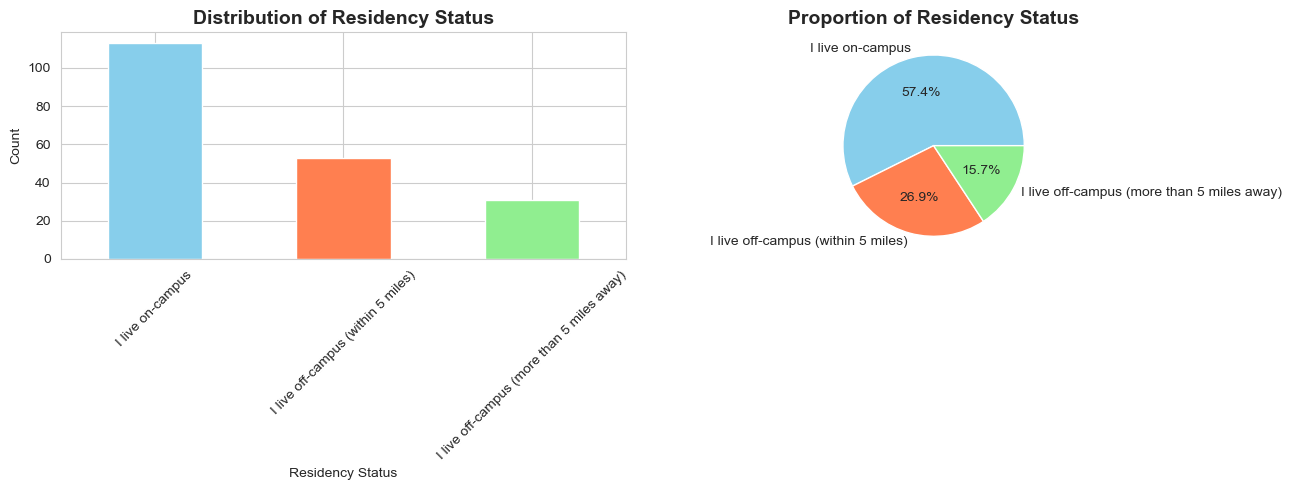

In [49]:
# Analyze target variable distribution
target_col = 'Do you live on-campus or off-campus?'

print("=" * 80)
print("TARGET VARIABLE DISTRIBUTION (Residency Status)")
print("=" * 80)
print(data_raw[target_col].value_counts())
print("\nProportions:")
print(data_raw[target_col].value_counts(normalize=True))

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
data_raw[target_col].value_counts().plot(kind='bar', ax=ax[0], color=['skyblue', 'coral', 'lightgreen'])
ax[0].set_title('Distribution of Residency Status', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Residency Status')
ax[0].set_ylabel('Count')
ax[0].tick_params(axis='x', rotation=45)

# Pie chart
data_raw[target_col].value_counts().plot(kind='pie', ax=ax[1], autopct='%1.1f%%', 
                                         colors=['skyblue', 'coral', 'lightgreen'])
ax[1].set_title('Proportion of Residency Status', fontsize=14, fontweight='bold')
ax[1].set_ylabel('')

plt.tight_layout()
plt.show()

---
## 2. Data Cleaning and Preprocessing <a id='section2'></a>

We'll use our custom data cleaning pipeline to:
- Simplify column names
- Handle missing values
- Clean text data
- Create one-hot encoded features
- Create TF-IDF features for text

In [50]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import warnings

class DataCleaner:
    """
    Comprehensive data cleaning class for survey data
    """

    def __init__(self, filepath='data.csv'):
        """Initialize with data file path"""
        self.filepath = filepath
        self.df = None
        self.df_cleaned = None
        self.column_mapping = {}

    def load_data(self):
        """Load the raw data"""
        print("Loading data...")
        self.df = pd.read_csv(self.filepath)
        print(f"Loaded {len(self.df)} rows and {len(self.df.columns)} columns")
        return self

    def simplify_column_names(self):
        """Simplify long column names to shorter, readable versions"""
        print("\nSimplifying column names...")

        # Define simplified column names
        simplified_names = {
            'Timestamp': 'timestamp',
            'Are you a current UCSD student or staff member?': 'role',
            'Do you live on-campus or off-campus?': 'housing',
            'What do you use as your PRIMARY access for delivery/shipping of packages? (if you use two or more sources equally, please select each one)': 'delivery_method',
            'How many packages/online orders do you have delivered to campus in a typical week?': 'packages_per_week',
            'How many items are usually included in each package/online order you have delivered to campus?': 'items_per_package',
            'How do you dispose of cardboard from packages you have delivered to campus?': 'cardboard_disposal',
            'How do you dispose of plastic (bags, bubble wrap, etc.) from packages you have delivered to campus?': 'plastic_disposal',
            'Please select the item types that you have delivered to campus': 'delivered_items',
            'Which item category/categories in the question above do you have delivered to campus MOST? (you may also specify items purchased/gifted to you)': 'most_delivered',
            'Are there any peak times during the academic year that you order more/less items to be delivered to campus (e.g. move-in, quarter beginning/end, holidays, etc.)? \nIf yes, please describe what time and if the item types you order change, too.': 'peak_times',
            'Please select the options(s) that best describe why you order packages to be delivered to campus instead of shopping in-store:': 'order_reasons',
            'Please select the item categories that you buy in-stores': 'instore_items',
            'Which item category/categories in the question above do you buy in-stores MOST? (you may also specify items purchased)': 'most_instore',
            'Do you typically buy from on or off-campus stores?': 'store_preference',
            'Would you be interested in any of the following shopping options being made more available/frequent? (especially to reduce online ordering)': 'shopping_interests',
            'Are there any items/goods that you would like the on-campus stores/vendors to offer? \n(identifying specific items, times they should be offered, and preferred price range is encouraged)': 'item_requests',
            'What communication method(s) do you get most of your campus news from?': 'communication_methods',
            'Is there anything else you would like us to know?': 'additional_comments'
        }

        self.df_cleaned = self.df.rename(columns=simplified_names)
        self.column_mapping = simplified_names

        print(f"Renamed {len(simplified_names)} columns")
        print("New columns:", list(self.df_cleaned.columns))
        return self

    def handle_missing_values(self, strategy='smart'):
        """
        Handle missing values with different strategies

        Args:
            strategy: 'smart' (default), 'drop', 'fill_unknown', or 'fill_mode'
        """
        print(f"\nHandling missing values with strategy: {strategy}")

        # Show missing value counts
        missing_counts = self.df_cleaned.isnull().sum()
        print("\nMissing values per column:")
        print(missing_counts[missing_counts > 0])

        if strategy == 'smart':
            # Smart strategy: different handling for different column types

            # For numerical-like columns, fill with 0 or mode
            numeric_like = ['packages_per_week', 'items_per_package']
            for col in numeric_like:
                if col in self.df_cleaned.columns:
                    self.df_cleaned[col].fillna('0', inplace=True)

            # For categorical columns, fill with 'Not Answered'
            categorical = ['delivery_method', 'cardboard_disposal', 'plastic_disposal',
                          'delivered_items', 'order_reasons', 'shopping_interests']
            for col in categorical:
                if col in self.df_cleaned.columns:
                    self.df_cleaned[col].fillna('Not Answered', inplace=True)

            # For text columns, fill with empty string
            text_cols = ['most_delivered', 'peak_times', 'most_instore',
                        'item_requests', 'additional_comments']
            for col in text_cols:
                if col in self.df_cleaned.columns:
                    self.df_cleaned[col].fillna('', inplace=True)

        elif strategy == 'drop':
            # Drop rows with any missing values
            before = len(self.df_cleaned)
            self.df_cleaned = self.df_cleaned.dropna()
            print(f"Dropped {before - len(self.df_cleaned)} rows")

        elif strategy == 'fill_unknown':
            # Fill all missing with 'Unknown'
            self.df_cleaned = self.df_cleaned.fillna('Unknown')

        elif strategy == 'fill_mode':
            # Fill with mode (most common value) for each column
            for col in self.df_cleaned.columns:
                if self.df_cleaned[col].isnull().any():
                    mode_val = self.df_cleaned[col].mode()
                    if len(mode_val) > 0:
                        self.df_cleaned[col].fillna(mode_val[0], inplace=True)

        print(f"\nRemaining missing values: {self.df_cleaned.isnull().sum().sum()}")
        return self

    def preprocess_text_simple(self, text):
        """
        Simple text preprocessing for NLP
        - Lowercase
        - Remove special characters
        - Strip whitespace
        """
        if pd.isna(text) or text == '':
            return ''

        # Convert to lowercase
        text = str(text).lower()

        # Remove special characters but keep spaces
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

        # Remove extra whitespace
        text = ' '.join(text.split())

        return text

    def clean_text_columns(self, columns=None):
        """
        Clean text columns with basic preprocessing

        Args:
            columns: List of column names to clean. If None, cleans all text columns
        """
        print("\nCleaning text columns...")

        if columns is None:
            # Default text columns
            columns = ['most_delivered', 'peak_times', 'most_instore',
                      'item_requests', 'additional_comments']

        for col in columns:
            if col in self.df_cleaned.columns:
                self.df_cleaned[f'{col}_cleaned'] = self.df_cleaned[col].apply(
                    self.preprocess_text_simple
                )
                print(f"Cleaned column: {col}")

        return self

    def extract_multi_select_categories(self, column):
        """
        Extract unique categories from multi-select columns (comma-separated)

        Args:
            column: Column name with comma-separated values

        Returns:
            List of unique categories
        """
        all_categories = set()

        for value in self.df_cleaned[column].dropna():
            if value and value != 'Not Answered':
                # Split by comma and clean
                categories = [cat.strip() for cat in str(value).split(',')]
                all_categories.update(categories)

        return sorted(list(all_categories))

    def one_hot_encode_multi_select(self, columns=None):
        """
        One-hot encode multi-select categorical columns

        Args:
            columns: List of column names with comma-separated values
        """
        print("\nOne-hot encoding multi-select columns...")

        if columns is None:
            columns = ['delivered_items', 'order_reasons', 'instore_items',
                      'communication_methods', 'shopping_interests']

        for col in columns:
            if col not in self.df_cleaned.columns:
                continue

            print(f"\nProcessing: {col}")
            categories = self.extract_multi_select_categories(col)
            print(f"Found {len(categories)} unique categories")

            # Create binary columns for each category
            for category in categories:
                col_name = f"{col}_{category.replace(' ', '_').replace('/', '_').replace('(', '').replace(')', '').lower()}"
                self.df_cleaned[col_name] = self.df_cleaned[col].apply(
                    lambda x: 1 if category in str(x) else 0
                )

        return self

    def label_encode_single_select(self, columns=None):
        """
        Label encode single-select categorical columns

        Args:
            columns: List of column names to label encode
        """
        print("\nLabel encoding single-select columns...")

        if columns is None:
            columns = ['role', 'housing', 'store_preference', 'packages_per_week']

        encoders = {}

        for col in columns:
            if col not in self.df_cleaned.columns:
                continue

            le = LabelEncoder()
            # Handle any remaining NaN values
            valid_mask = self.df_cleaned[col].notna()
            self.df_cleaned.loc[valid_mask, f'{col}_encoded'] = le.fit_transform(
                self.df_cleaned.loc[valid_mask, col]
            )
            encoders[col] = le

            print(f"Encoded {col}: {len(le.classes_)} classes")
            print(f"  Classes: {list(le.classes_)}")

        return encoders

    def create_tfidf_features(self, text_columns=None, max_features=50):
        """
        Create TF-IDF features from text columns

        Args:
            text_columns: List of text column names
            max_features: Maximum number of features per column

        Returns:
            Dictionary of fitted TF-IDF vectorizers
        """
        print(f"\nCreating TF-IDF features (max {max_features} features per column)...")

        if text_columns is None:
            text_columns = ['most_delivered_cleaned', 'most_instore_cleaned',
                           'peak_times_cleaned']

        vectorizers = {}

        for col in text_columns:
            if col not in self.df_cleaned.columns:
                continue

            # Skip if all empty
            if self.df_cleaned[col].str.len().sum() == 0:
                print(f"Skipping {col} - all empty")
                continue

            tfidf = TfidfVectorizer(max_features=max_features, min_df=2,
                                   stop_words='english')

            try:
                tfidf_matrix = tfidf.fit_transform(self.df_cleaned[col])

                # Create columns for each feature
                feature_names = tfidf.get_feature_names_out()
                tfidf_df = pd.DataFrame(
                    tfidf_matrix.toarray(),
                    columns=[f'{col}_tfidf_{name}' for name in feature_names]
                )

                # Add to main dataframe
                self.df_cleaned = pd.concat([self.df_cleaned, tfidf_df], axis=1)
                vectorizers[col] = tfidf

                print(f"Created {len(feature_names)} TF-IDF features for {col}")

            except Exception as e:
                print(f"Error processing {col}: {e}")

        return vectorizers

    def get_feature_columns_for_ml(self):
        """
        Get list of feature columns suitable for ML models (numeric only)

        Returns:
            List of column names
        """
        # Get all numeric columns and encoded columns
        feature_cols = []

        for col in self.df_cleaned.columns:
            # Include encoded columns, one-hot columns, tfidf, embeddings
            if any(suffix in col for suffix in ['_encoded', '_tfidf_', '_embed_']) or \
               self.df_cleaned[col].dtype in ['int64', 'float64']:
                feature_cols.append(col)

        return feature_cols

    def save_cleaned_data(self, output_path='data_cleaned.csv'):
        """Save cleaned data to CSV"""
        print(f"\nSaving cleaned data to {output_path}...")
        self.df_cleaned.to_csv(output_path, index=False)
        print(f"Saved {len(self.df_cleaned)} rows and {len(self.df_cleaned.columns)} columns")
        return self

    def get_summary(self):
        """Print summary of cleaned data"""
        print("\n" + "="*60)
        print("DATA CLEANING SUMMARY")
        print("="*60)
        print(f"Original shape: {self.df.shape}")
        print(f"Cleaned shape: {self.df_cleaned.shape}")
        print(f"\nColumns added: {self.df_cleaned.shape[1] - self.df.shape[1]}")
        print(f"Missing values: {self.df_cleaned.isnull().sum().sum()}")
        print(f"\nData types:")
        print(self.df_cleaned.dtypes.value_counts())

        # Get ML-ready features
        ml_features = self.get_feature_columns_for_ml()
        print(f"\nML-ready feature columns: {len(ml_features)}")

        return self


# ============================================================================
# MAIN CLEANING PIPELINE
# ============================================================================

def clean_data_pipeline(
    input_file='data.csv',
    output_file='data_cleaned.csv',
    use_tfidf=True,
):
    """
    Main data cleaning pipeline with multiple options

    Args:
        input_file: Path to raw data CSV
        output_file: Path to save cleaned data
        use_tfidf: Whether to create TF-IDF features (recommended)
    """

    # Initialize cleaner
    cleaner = DataCleaner(input_file)

    # Step 1: Load and simplify
    cleaner.load_data()
    cleaner.simplify_column_names()

    # Step 2: Handle missing values
    cleaner.handle_missing_values(strategy='smart')

    # Step 3: Clean text columns
    cleaner.clean_text_columns()

    # Step 4: Encode categorical variables
    # One-hot encode multi-select columns
    cleaner.one_hot_encode_multi_select()

    # Label encode single-select columns
    label_encoders = cleaner.label_encode_single_select()

    # Step 5: Create text features
    if use_tfidf:
        tfidf_vectorizers = cleaner.create_tfidf_features(max_features=30)

    # Step 6: Save and summarize
    cleaner.save_cleaned_data(output_file)
    cleaner.get_summary()

    # Print example ML-ready columns
    ml_cols = cleaner.get_feature_columns_for_ml()
    print(f"\nExample ML-ready columns (first 10):")
    for col in ml_cols[:10]:
        print(f"  - {col}")

    return cleaner



In [51]:
from data_cleaning import clean_data_pipeline


print("Running data cleaning pipeline...\n")
cleaner = clean_data_pipeline(
    input_file='data.csv',
    output_file='data_cleaned.csv',
    use_tfidf=True,
)

Running data cleaning pipeline...

Loading data...
Loaded 197 rows and 19 columns

Simplifying column names...
Renamed 19 columns
New columns: ['timestamp', 'role', 'housing', 'delivery_method', 'packages_per_week', 'items_per_package', 'cardboard_disposal', 'plastic_disposal', 'delivered_items', 'most_delivered', 'peak_times', 'order_reasons', 'instore_items', 'most_instore', 'store_preference', 'shopping_interests', 'item_requests', 'communication_methods', 'additional_comments']

Handling missing values with strategy: smart

Missing values per column:
items_per_package       40
cardboard_disposal      39
plastic_disposal        39
delivered_items         39
most_delivered          41
peak_times              85
order_reasons           46
shopping_interests      14
item_requests          131
additional_comments    177
dtype: int64

Remaining missing values: 0

Cleaning text columns...
Cleaned column: most_delivered
Cleaned column: peak_times
Cleaned column: most_instore
Cleaned column

In [52]:
df = pd.read_csv('data_cleaned.csv')

print("Cleaned Data Shape:", df.shape)
print(f"\nColumns increased from {data_raw.shape[1]} to {df.shape[1]}")
print(f"New features created: {df.shape[1] - data_raw.shape[1]}")

df['housing_binary'] = df['housing'].apply(lambda x: 1 if 'on-campus' in str(x).lower() else 0)

print("\n" + "=" * 80)
print("BINARY TARGET VARIABLE")
print("=" * 80)
print("1 = On-Campus, 0 = Off-Campus")
print(df['housing_binary'].value_counts())
print(f"\nClass Balance: {df['housing_binary'].mean():.2%} on-campus")

Cleaned Data Shape: (197, 185)

Columns increased from 19 to 185
New features created: 166

BINARY TARGET VARIABLE
1 = On-Campus, 0 = Off-Campus
housing_binary
1    113
0     84
Name: count, dtype: int64

Class Balance: 57.36% on-campus


In [53]:
feature_cols = []

for col in df.columns:
    if any(keyword in col for keyword in [
        '_encoded', '_tfidf_',
        'delivered_items_', 'order_reasons_',
        'instore_items_', 'communication_methods_',
        'shopping_interests_', 'delivery_method_'
    ]):
        if 'housing' not in col:
            feature_cols.append(col)

print(f"Selected {len(feature_cols)} features for modeling")
print("\nFeature types:")
print(f"  - Encoded: {len([c for c in feature_cols if '_encoded' in c])}")
print(f"  - One-hot: {len([c for c in feature_cols if any(p in c for p in ['delivered_items_', 'order_reasons_'])])}")
print(f"  - TF-IDF: {len([c for c in feature_cols if '_tfidf_' in c])}")

# Prepare feature matrix and target
X = df[feature_cols].fillna(0)
y = df['housing_binary']

print(f"\nFinal dataset: X={X.shape}, y={y.shape}")

Selected 160 features for modeling

Feature types:
  - Encoded: 3
  - One-hot: 40
  - TF-IDF: 82

Final dataset: X=(197, 160), y=(197,)


---
## 3. Exploratory Data Analysis (EDA) <a id='section3'></a>

In [54]:
# Basic statistics
print("=" * 80)
print("DESCRIPTIVE STATISTICS")
print("=" * 80)

on_campus = df[df['housing_binary'] == 1]
off_campus = df[df['housing_binary'] == 0]

print(f"\nSample sizes:")
print(f"  On-Campus: {len(on_campus)} ({len(on_campus)/len(df)*100:.1f}%)")
print(f"  Off-Campus: {len(off_campus)} ({len(off_campus)/len(df)*100:.1f}%)")

# Compare key variables
if 'packages_per_week' in df.columns:
    print("\n" + "-" * 80)
    print("Package Delivery Frequency:")
    print("-" * 80)
    print("\nOn-Campus:")
    print(on_campus['packages_per_week'].value_counts().head())
    print("\nOff-Campus:")
    print(off_campus['packages_per_week'].value_counts().head())

if 'store_preference' in df.columns:
    print("\n" + "-" * 80)
    print("Store Preference:")
    print("-" * 80)
    print("\nOn-Campus:")
    print(on_campus['store_preference'].value_counts())
    print("\nOff-Campus:")
    print(off_campus['store_preference'].value_counts())

DESCRIPTIVE STATISTICS

Sample sizes:
  On-Campus: 113 (57.4%)
  Off-Campus: 84 (42.6%)

--------------------------------------------------------------------------------
Package Delivery Frequency:
--------------------------------------------------------------------------------

On-Campus:
packages_per_week
<1                                                        79
1                                                         23
2                                                          5
I have never ordered an item to be delivered to campus     4
4 or more                                                  2
Name: count, dtype: int64

Off-Campus:
packages_per_week
<1                                                        36
I have never ordered an item to be delivered to campus    35
2                                                          6
1                                                          5
3                                                          2
Name: count, dtype: int6

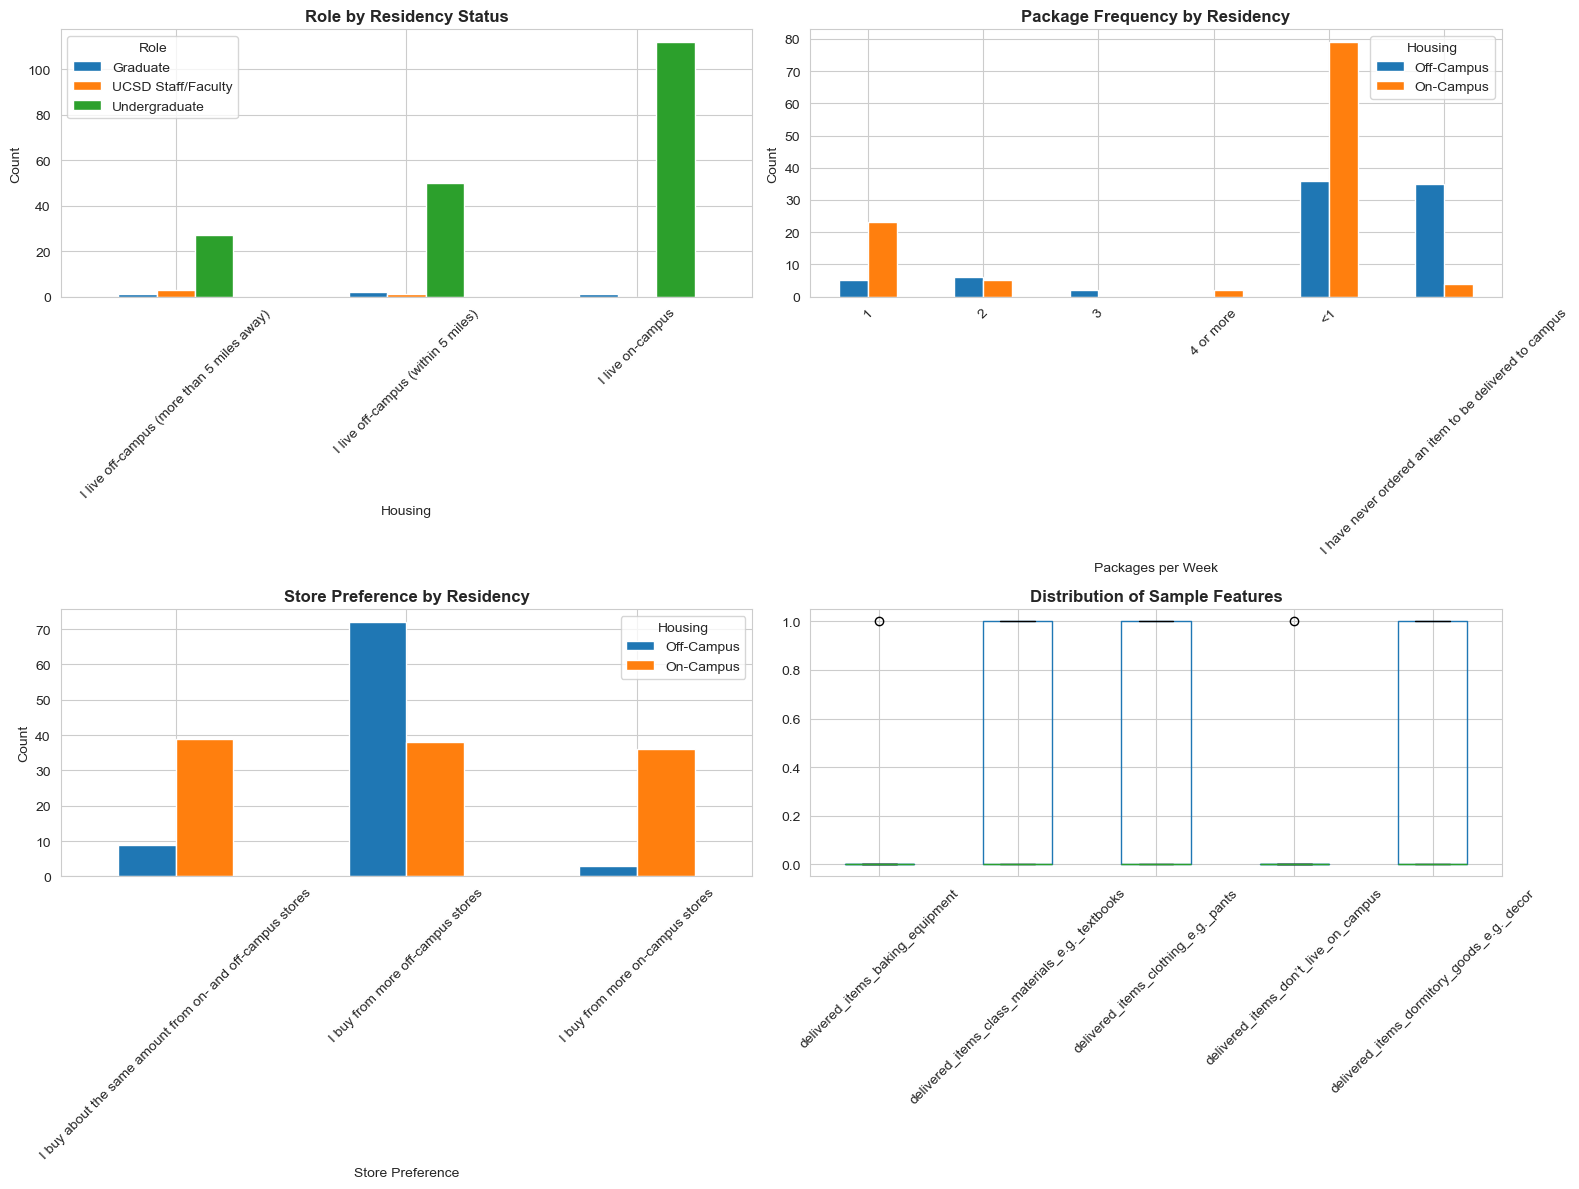

In [55]:
# Visualize key differences
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Role distribution by housing
if 'role' in df.columns:
    pd.crosstab(df['housing'], df['role']).plot(kind='bar', ax=axes[0, 0])
    axes[0, 0].set_title('Role by Residency Status', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Housing')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].legend(title='Role')

# 2. Package frequency by housing
if 'packages_per_week' in df.columns:
    pd.crosstab(df['housing_binary'], df['packages_per_week']).T.plot(kind='bar', ax=axes[0, 1])
    axes[0, 1].set_title('Package Frequency by Residency', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Packages per Week')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].legend(['Off-Campus', 'On-Campus'], title='Housing')

# 3. Store preference by housing
if 'store_preference' in df.columns:
    pd.crosstab(df['housing_binary'], df['store_preference']).T.plot(kind='bar', ax=axes[1, 0])
    axes[1, 0].set_title('Store Preference by Residency', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Store Preference')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].legend(['Off-Campus', 'On-Campus'], title='Housing')

# 4. Feature distribution (sample of numeric features)
numeric_sample = X.iloc[:, :5]
numeric_sample.boxplot(ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Sample Features', fontsize=12, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

---
## 4. Feature Relationships and Correlation Analysis <a id='section4'></a>

In [56]:
# Calculate correlation matrix
print("Computing correlation matrix...")
print("(This may take a moment with many features)\n")

correlation_matrix = X.corr()

# Find highly correlated features
high_corr_threshold = 0.8
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > high_corr_threshold:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

print("=" * 80)
print(f"HIGHLY CORRELATED FEATURES (|r| > {high_corr_threshold})")
print("=" * 80)
print(f"Found {len(high_corr_pairs)} pairs of highly correlated features\n")

if len(high_corr_pairs) > 0:
    for feat1, feat2, corr in high_corr_pairs[:10]:  # Show first 10
        print(f"{feat1[:40]:40s} <-> {feat2[:40]:40s} : {corr:.3f}")
    if len(high_corr_pairs) > 10:
        print(f"\n... and {len(high_corr_pairs) - 10} more pairs")
else:
    print("No highly correlated feature pairs found.")

Computing correlation matrix...
(This may take a moment with many features)

HIGHLY CORRELATED FEATURES (|r| > 0.8)
Found 25 pairs of highly correlated features

delivered_items_class_materials_e.g._tex <-> delivered_items_notebooks                : 1.000
delivered_items_clothing_e.g._pants      <-> delivered_items_shoes                    : 1.000
delivered_items_dormitory_goods_e.g._dec <-> delivered_items_cups_plates              : 1.000
delivered_items_electronics_e.g._tablet  <-> delivered_items_headphones               : 1.000
delivered_items_food_groceries_e.g._past <-> delivered_items_snack_foods              : 1.000
delivered_items_gifted_items_from_family <-> delivered_items_friends                  : 1.000
delivered_items_lab_materials_e.g._glove <-> delivered_items_hardware                 : 0.961
delivered_items_magazines                <-> most_delivered_cleaned_tfidf_socks       : 0.833
delivered_items_mobility_items_e.g._scoo <-> delivered_items_helmet                   


CORRELATION WITH TARGET VARIABLE

Top 15 features most correlated with residency status:
delivered_items_etc.                                                                0.503508
order_reasons_transportation_issues_ex._limited_no_access_to_a_car                  0.394715
order_reasons_items_i_want_are_not_offered_by_on-campus_nearby_stores_or_vendors    0.312304
delivered_items_friends                                                             0.296970
delivered_items_gifted_items_from_family                                            0.296970
delivered_items_clothing_e.g._pants                                                 0.263568
delivered_items_shoes                                                               0.263568
delivered_items_deodorant                                                           0.253234
delivered_items_personal_care_goods_e.g._toothpaste                                 0.253234
delivered_items_cups_plates                                              

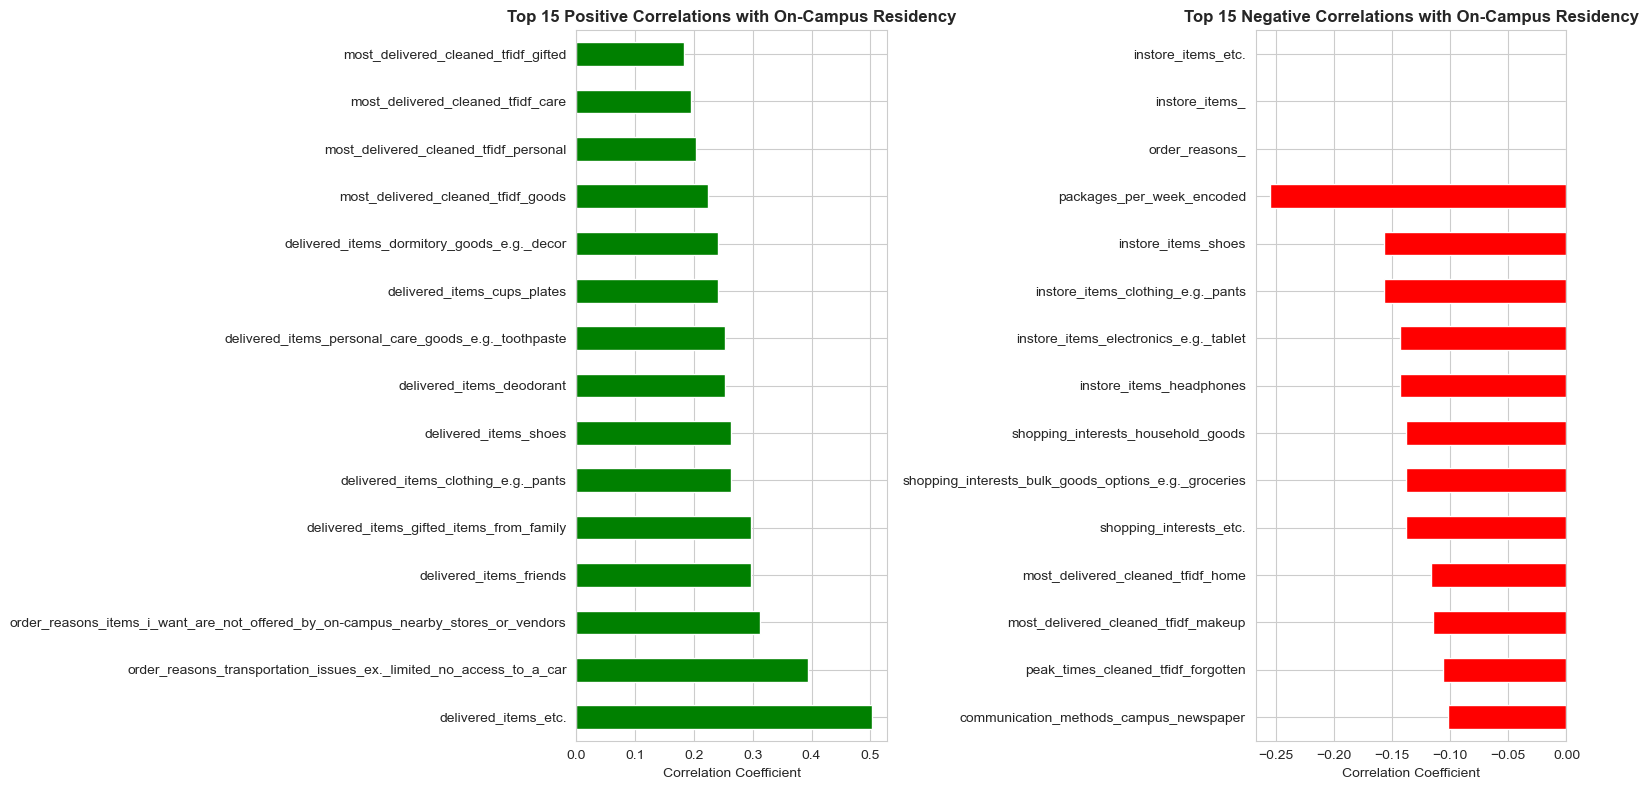

In [57]:
# Visualize correlation with target
print("\n" + "=" * 80)
print("CORRELATION WITH TARGET VARIABLE")
print("=" * 80)

# Add target to calculate correlations
X_with_target = X.copy()
X_with_target['target'] = y

# Get correlations with target
target_corr = X_with_target.corr()['target'].sort_values(ascending=False)
target_corr = target_corr.drop('target')  # Remove self-correlation

print("\nTop 15 features most correlated with residency status:")
print(target_corr.head(15))

print("\nBottom 15 features (negatively correlated):")
print(target_corr.tail(15))

# Plot top correlations
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Positive correlations
target_corr.head(15).plot(kind='barh', ax=ax[0], color='green')
ax[0].set_title('Top 15 Positive Correlations with On-Campus Residency', fontsize=12, fontweight='bold')
ax[0].set_xlabel('Correlation Coefficient')

# Negative correlations
target_corr.tail(15).plot(kind='barh', ax=ax[1], color='red')
ax[1].set_title('Top 15 Negative Correlations with On-Campus Residency', fontsize=12, fontweight='bold')
ax[1].set_xlabel('Correlation Coefficient')

plt.tight_layout()
plt.show()

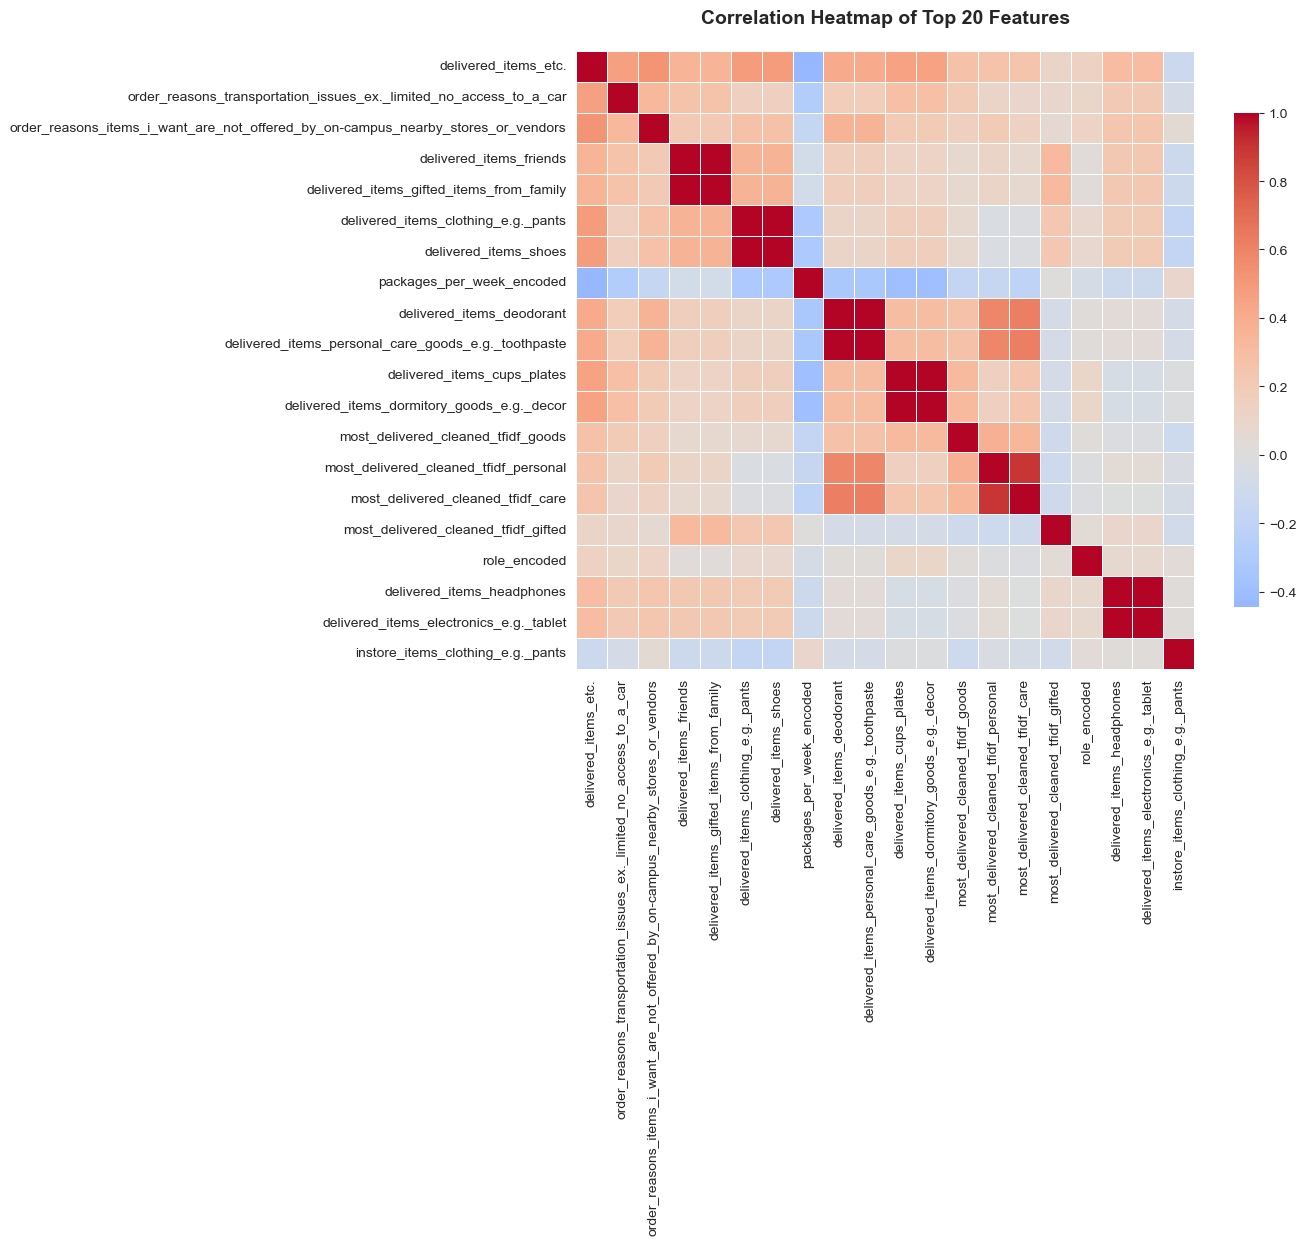

In [58]:
# Heatmap of top features
top_features = abs(target_corr).nlargest(20).index.tolist()
top_corr_matrix = X[top_features].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(top_corr_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of Top 20 Features', fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

---
## 5. Multicollinearity Analysis (VIF) <a id='section5'></a>

We'll check for multicollinearity using Variance Inflation Factor (VIF).
- VIF < 5: Low multicollinearity
- VIF 5-10: Moderate multicollinearity
- VIF > 10: High multicollinearity (problematic for regression)

VARIANCE INFLATION FACTOR (VIF) ANALYSIS

Note: Calculating VIF for top 30 features (full calculation would be time-consuming)

VIF Results:
                                                                             Feature       VIF
                                            delivered_items_gifted_items_from_family       inf
                                                             delivered_items_friends       inf
                                                 delivered_items_clothing_e.g._pants       inf
                                 delivered_items_personal_care_goods_e.g._toothpaste       inf
                                                           delivered_items_deodorant       inf
                                                               delivered_items_shoes       inf
                                          delivered_items_dormitory_goods_e.g._decor       inf
                                                         delivered_items_cups_plates       inf
    

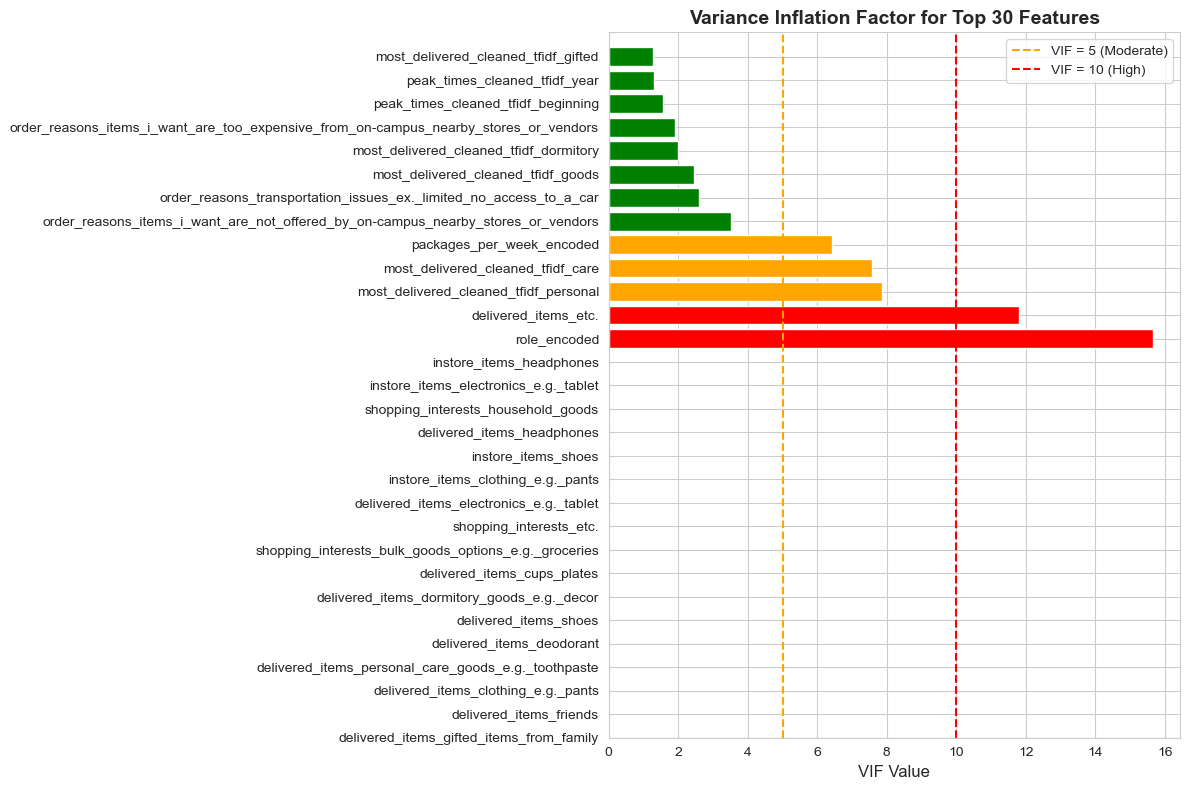

In [59]:
# Calculate VIF for a sample of features (calculating for all features would take too long)
print("=" * 80)
print("VARIANCE INFLATION FACTOR (VIF) ANALYSIS")
print("=" * 80)
print("\nNote: Calculating VIF for top 30 features (full calculation would be time-consuming)\n")

# Select top features based on correlation with target
top_30_features = abs(target_corr).nlargest(30).index.tolist()
X_vif = X[top_30_features].copy()

# Calculate VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]
vif_data = vif_data.sort_values('VIF', ascending=False)

print("VIF Results:")
print(vif_data.to_string(index=False))

# Count features by multicollinearity level
print("\n" + "-" * 80)
print("Multicollinearity Summary:")
print("-" * 80)
print(f"Low multicollinearity (VIF < 5): {len(vif_data[vif_data['VIF'] < 5])} features")
print(f"Moderate multicollinearity (5 <= VIF < 10): {len(vif_data[(vif_data['VIF'] >= 5) & (vif_data['VIF'] < 10)])} features")
print(f"High multicollinearity (VIF >= 10): {len(vif_data[vif_data['VIF'] >= 10])} features")

# Visualize
plt.figure(figsize=(12, 8))
colors = ['green' if x < 5 else 'orange' if x < 10 else 'red' for x in vif_data['VIF']]
plt.barh(range(len(vif_data)), vif_data['VIF'], color=colors)
plt.yticks(range(len(vif_data)), vif_data['Feature'])
plt.xlabel('VIF Value', fontsize=12)
plt.title('Variance Inflation Factor for Top 30 Features', fontsize=14, fontweight='bold')
plt.axvline(x=5, color='orange', linestyle='--', label='VIF = 5 (Moderate)')
plt.axvline(x=10, color='red', linestyle='--', label='VIF = 10 (High)')
plt.legend()
plt.tight_layout()
plt.show()

---
## 6. Principal Component Analysis (PCA) <a id='section6'></a>

PCA helps us:
1. Reduce dimensionality
2. Visualize high-dimensional data
3. Understand variance structure
4. Potentially improve model performance

In [60]:
print("=" * 80)
print("PRINCIPAL COMPONENT ANALYSIS")
print("=" * 80)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculate cumulative explained variance
cumsum_var = np.cumsum(pca.explained_variance_ratio_)

print(f"\nOriginal number of features: {X.shape[1]}")
print(f"\nExplained variance by components:")
print(f"  First 5 components: {cumsum_var[4]:.2%}")
print(f"  First 10 components: {cumsum_var[9]:.2%}")
print(f"  First 20 components: {cumsum_var[19]:.2%}")
print(f"  First 50 components: {cumsum_var[49]:.2%}")

# Find number of components for 90% variance
n_components_90 = np.argmax(cumsum_var >= 0.90) + 1
print(f"\nComponents needed for 90% variance: {n_components_90}")

# Find number of components for 95% variance
n_components_95 = np.argmax(cumsum_var >= 0.95) + 1
print(f"Components needed for 95% variance: {n_components_95}")

PRINCIPAL COMPONENT ANALYSIS

Original number of features: 160

Explained variance by components:
  First 5 components: 16.82%
  First 10 components: 27.92%
  First 20 components: 45.03%
  First 50 components: 77.02%

Components needed for 90% variance: 73
Components needed for 95% variance: 87


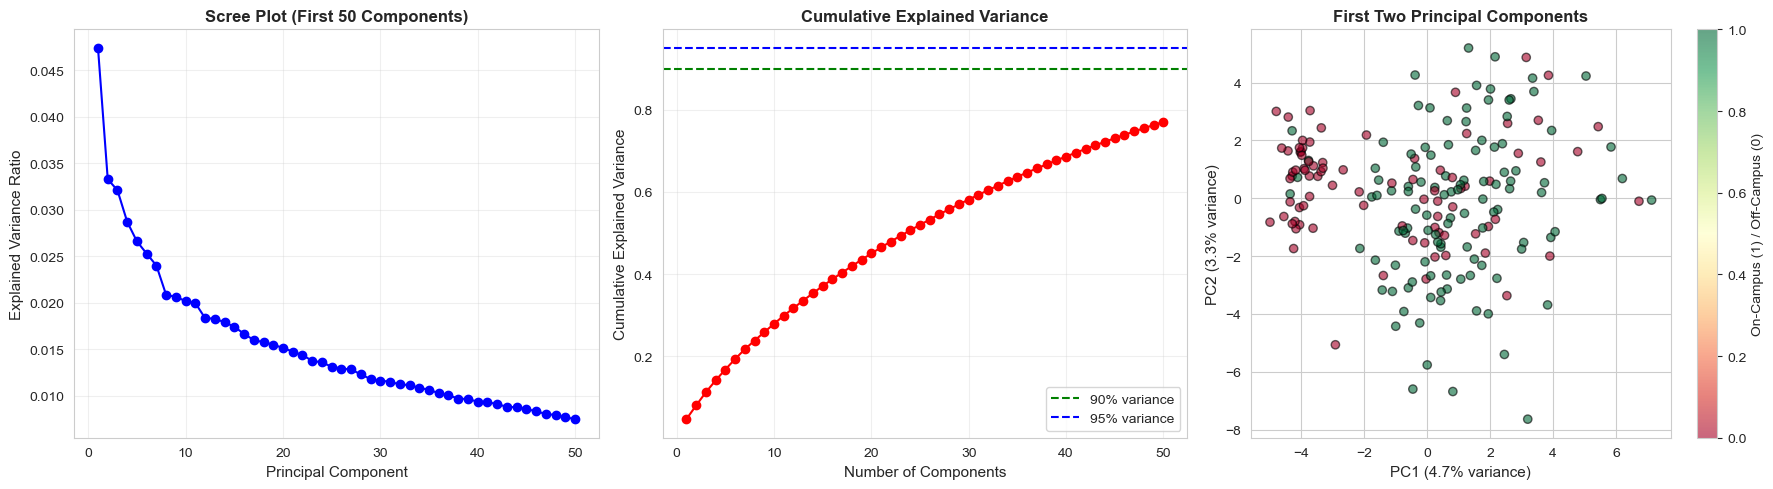

In [61]:
# Visualize PCA results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Scree plot
axes[0].plot(range(1, min(51, len(pca.explained_variance_ratio_)+1)), 
             pca.explained_variance_ratio_[:50], 'bo-')
axes[0].set_xlabel('Principal Component', fontsize=11)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=11)
axes[0].set_title('Scree Plot (First 50 Components)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# 2. Cumulative variance
axes[1].plot(range(1, min(51, len(cumsum_var)+1)), cumsum_var[:50], 'ro-')
axes[1].axhline(y=0.90, color='green', linestyle='--', label='90% variance')
axes[1].axhline(y=0.95, color='blue', linestyle='--', label='95% variance')
axes[1].set_xlabel('Number of Components', fontsize=11)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=11)
axes[1].set_title('Cumulative Explained Variance', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. 2D visualization of first 2 PCs
scatter = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='RdYlGn', alpha=0.6, edgecolors='k')
axes[2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
axes[2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
axes[2].set_title('First Two Principal Components', fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=axes[2], label='On-Campus (1) / Off-Campus (0)')

plt.tight_layout()
plt.show()

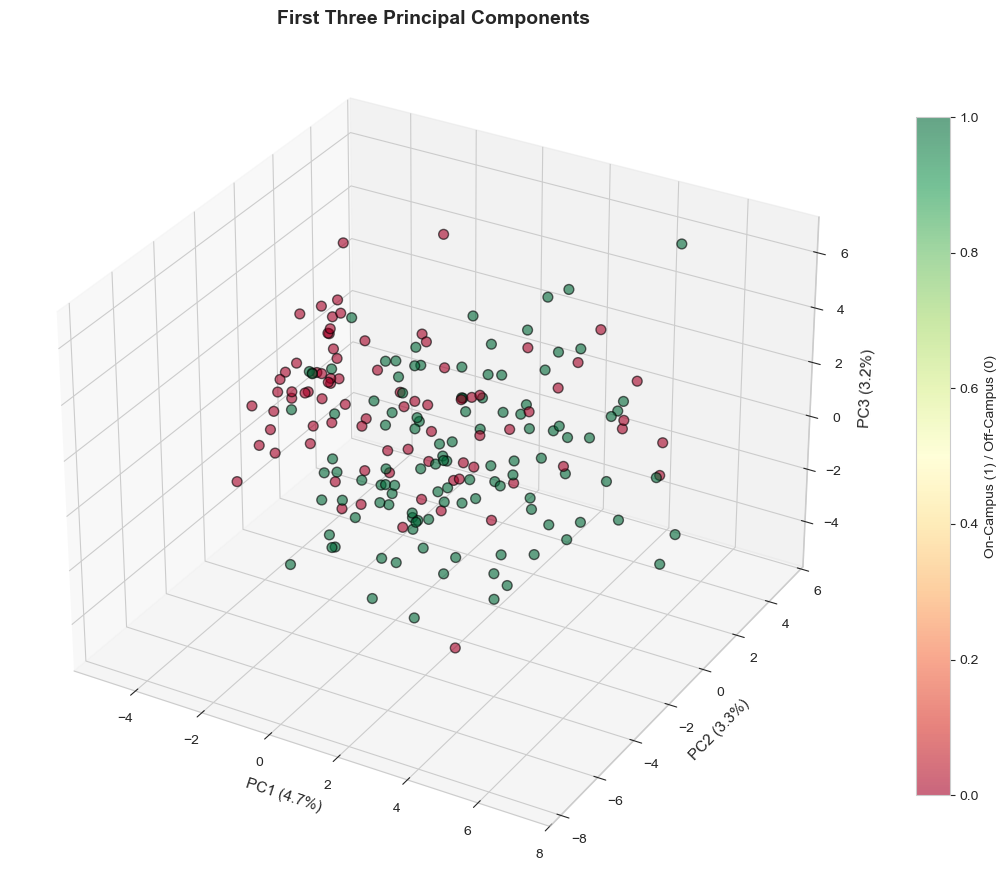

In [62]:
# 3D visualization
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
                    c=y, cmap='RdYlGn', alpha=0.6, edgecolors='k', s=50)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%})', fontsize=11)
ax.set_title('First Three Principal Components', fontsize=14, fontweight='bold')

plt.colorbar(scatter, ax=ax, label='On-Campus (1) / Off-Campus (0)', shrink=0.8)
plt.tight_layout()
plt.show()

---
## 7. Hypothesis Testing <a id='section7'></a>

We'll test several hypotheses about differences between on-campus and off-campus students: Mann-Whitney U test for ordinal/non-normal numeric variables


In [63]:
print("\n" + "=" * 80)
print("HYPOTHESIS TESTING: Numeric Features (Mann-Whitney U Test)")
print("=" * 80)
print("\nH0: The distributions are the same for on-campus and off-campus students")
print("H1: The distributions are different")
print("\nSignificance level: α = 0.05\n")

# Test top 20 features most correlated with target
test_features = abs(target_corr).nlargest(20).index.tolist()
mann_whitney_results = []

for feature in test_features[:10]:  # Test top 10 to avoid clutter
    on_campus_vals = X[feature][y == 1]
    off_campus_vals = X[feature][y == 0]
    
    # Perform Mann-Whitney U test
    statistic, p_value = mannwhitneyu(on_campus_vals, off_campus_vals, alternative='two-sided')
    
    mann_whitney_results.append({
        'Feature': feature,
        'U-Statistic': statistic,
        'p-value': p_value,
        'On-Campus Mean': on_campus_vals.mean(),
        'Off-Campus Mean': off_campus_vals.mean(),
        'Significant': 'Yes' if p_value < 0.05 else 'No'
    })

# Display results
mann_df = pd.DataFrame(mann_whitney_results)
print(mann_df.to_string(index=False))

print("\n" + "-" * 80)
print(f"Significant features (p < 0.05): {len(mann_df[mann_df['Significant'] == 'Yes'])} out of {len(mann_df)}")
print("-" * 80)


HYPOTHESIS TESTING: Numeric Features (Mann-Whitney U Test)

H0: The distributions are the same for on-campus and off-campus students
H1: The distributions are different

Significance level: α = 0.05

                                                                         Feature  U-Statistic      p-value  On-Campus Mean  Off-Campus Mean Significant
                                                            delivered_items_etc.       6725.0 1.823809e-12        0.964602         0.547619         Yes
              order_reasons_transportation_issues_ex._limited_no_access_to_a_car       6627.0 3.303401e-08        0.610619         0.214286         Yes
order_reasons_items_i_want_are_not_offered_by_on-campus_nearby_stores_or_vendors       6244.5 1.237955e-05        0.637168         0.321429         Yes
                                                         delivered_items_friends       6069.5 3.238578e-05        0.433628         0.154762         Yes
                                       

---
## 8. Logistic Regression - Assumptions and Modeling <a id='section8'></a>

### Logistic Regression Assumptions:
1. **Binary outcome** - ✓ (on-campus vs off-campus)
2. **Linear relationship between logit and predictors** - Will check
3. **Independence of observations** - ✓ (survey responses)
4. **No multicollinearity** - Checked via VIF
5. **Large sample size** - ✓ (197 observations with many features)

In [ ]:
print("=" * 80)
print("LOGISTIC REGRESSION MODELING")
print("=" * 80)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nClass distribution in train set:")
print(y_train.value_counts())
print(f"\nClass distribution in test set:")
print(y_test.value_counts())

LOGISTIC REGRESSION MODELING

Train set: 157 samples
Test set: 40 samples

Class distribution in train set:
housing_binary
1    90
0    67
Name: count, dtype: int64

Class distribution in test set:
housing_binary
1    23
0    17
Name: count, dtype: int64


In [65]:
# Train basic logistic regression
print("\n" + "-" * 80)
print("Training Logistic Regression (Basic)")
print("-" * 80)

lr_basic = LogisticRegression(max_iter=1000)
lr_basic.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_basic.predict(X_test)
y_pred_proba_lr = lr_basic.predict_proba(X_test)[:, 1]

# Evaluate
accuracy_lr = accuracy_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)

print(f"\nTest Accuracy: {accuracy_lr:.4f}")
print(f"ROC AUC Score: {auc_lr:.4f}")

# Cross-validation
cv_scores_lr = cross_val_score(lr_basic, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy: {cv_scores_lr.mean():.4f} (+/- {cv_scores_lr.std():.4f})")

print("\n" + "-" * 80)
print("Classification Report:")
print("-" * 80)
print(classification_report(y_test, y_pred_lr, target_names=['Off-Campus', 'On-Campus']))


--------------------------------------------------------------------------------
Training Logistic Regression (Basic)
--------------------------------------------------------------------------------

Test Accuracy: 0.6000
ROC AUC Score: 0.7059

Cross-Validation Accuracy: 0.6694 (+/- 0.0940)

--------------------------------------------------------------------------------
Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

  Off-Campus       0.52      0.71      0.60        17
   On-Campus       0.71      0.52      0.60        23

    accuracy                           0.60        40
   macro avg       0.61      0.61      0.60        40
weighted avg       0.63      0.60      0.60        40



In [ ]:
# Train regularized logistic regression (L2 penalty)
print("\n" + "-" * 80)
print("Training Logistic Regression with L2 Regularization")
print("-" * 80)

# Grid search for best C parameter
param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_lr = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid_lr,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

print("\nPerforming grid search...")
grid_lr.fit(X_train, y_train)

print(f"\nBest C parameter: {grid_lr.best_params_['C']}")
print(f"Best CV score: {grid_lr.best_score_:.4f}")

# Best model
lr_best = grid_lr.best_estimator_
y_pred_lr_best = lr_best.predict(X_test)
y_pred_proba_lr_best = lr_best.predict_proba(X_test)[:, 1]

accuracy_lr_best = accuracy_score(y_test, y_pred_lr_best)
auc_lr_best = roc_auc_score(y_test, y_pred_proba_lr_best)

print(f"\nTest Accuracy: {accuracy_lr_best:.4f}")
print(f"ROC AUC Score: {auc_lr_best:.4f}")


--------------------------------------------------------------------------------
Training Logistic Regression with L2 Regularization
--------------------------------------------------------------------------------

Performing grid search...

Best C parameter: 0.01
Best CV score: 0.7272

Test Accuracy: 0.7750
ROC AUC Score: 0.7238



LOGISTIC REGRESSION COEFFICIENTS

Top features increasing likelihood of ON-CAMPUS residency:
--------------------------------------------------------------------------------
                                                                         Feature  Coefficient
              order_reasons_transportation_issues_ex._limited_no_access_to_a_car     0.117111
                                                            delivered_items_etc.     0.098556
                                                         delivered_items_friends     0.080479
                                        delivered_items_gifted_items_from_family     0.080479
order_reasons_items_i_want_are_not_offered_by_on-campus_nearby_stores_or_vendors     0.075929
                                      delivered_items_dormitory_goods_e.g._decor     0.075341
                                                     delivered_items_cups_plates     0.075341
                                                           delivered_item

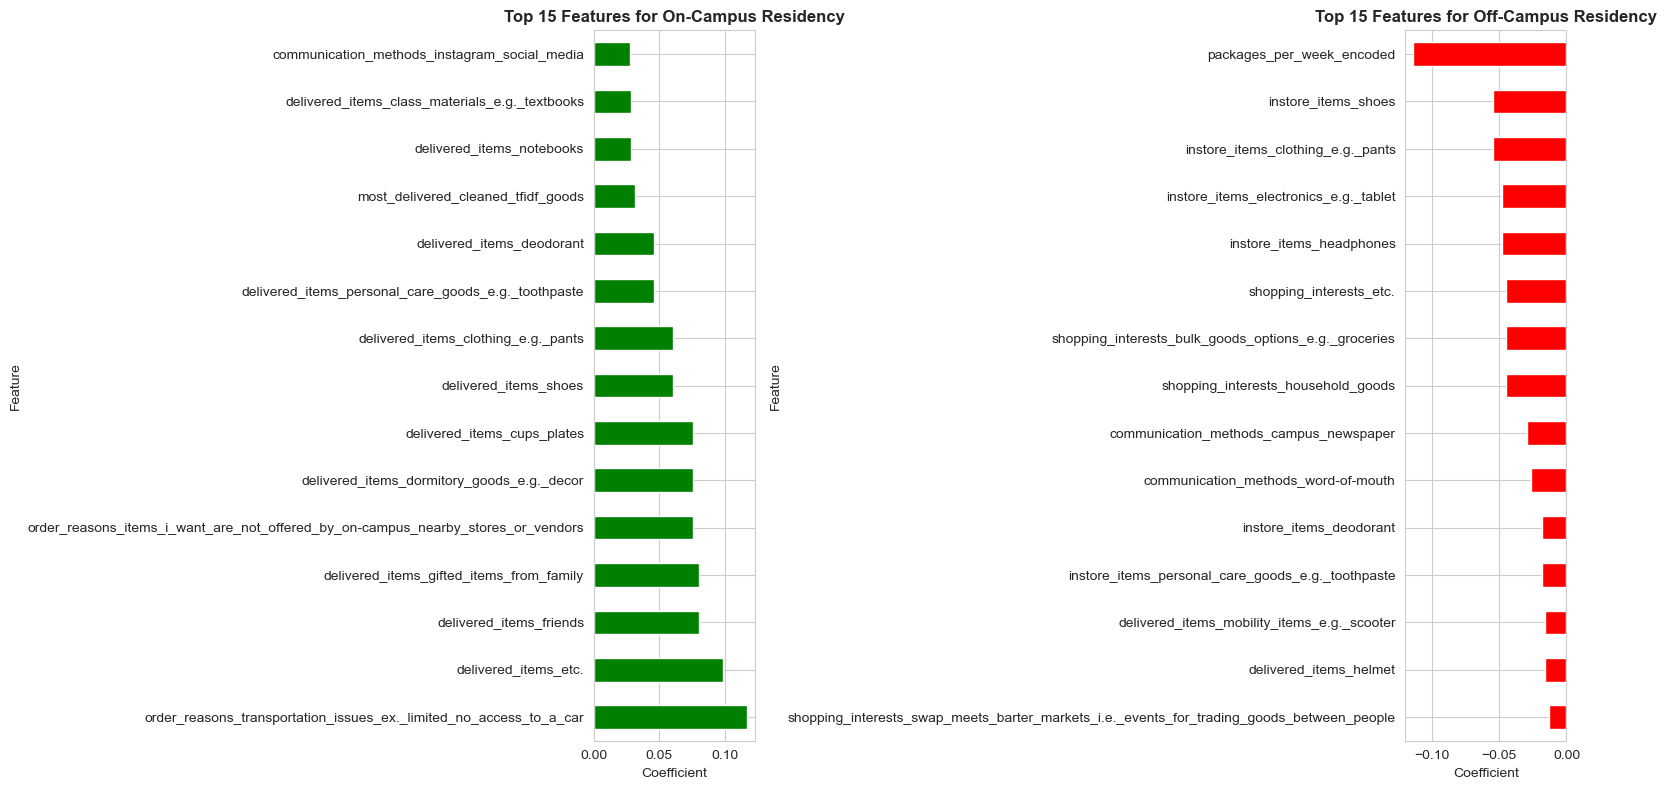

In [67]:
# Analyze coefficients
print("\n" + "=" * 80)
print("LOGISTIC REGRESSION COEFFICIENTS")
print("=" * 80)
print("\nTop features increasing likelihood of ON-CAMPUS residency:")
print("-" * 80)

coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_best.coef_[0]
}).sort_values('Coefficient', ascending=False)

print(coef_df.head(15).to_string(index=False))

print("\n" + "-" * 80)
print("Top features increasing likelihood of OFF-CAMPUS residency:")
print("-" * 80)
print(coef_df.tail(15).to_string(index=False))

# Visualize top coefficients
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

coef_df.head(15).plot(x='Feature', y='Coefficient', kind='barh', ax=ax[0], color='green', legend=False)
ax[0].set_title('Top 15 Features for On-Campus Residency', fontsize=12, fontweight='bold')
ax[0].set_xlabel('Coefficient')

coef_df.tail(15).plot(x='Feature', y='Coefficient', kind='barh', ax=ax[1], color='red', legend=False)
ax[1].set_title('Top 15 Features for Off-Campus Residency', fontsize=12, fontweight='bold')
ax[1].set_xlabel('Coefficient')

plt.tight_layout()
plt.show()

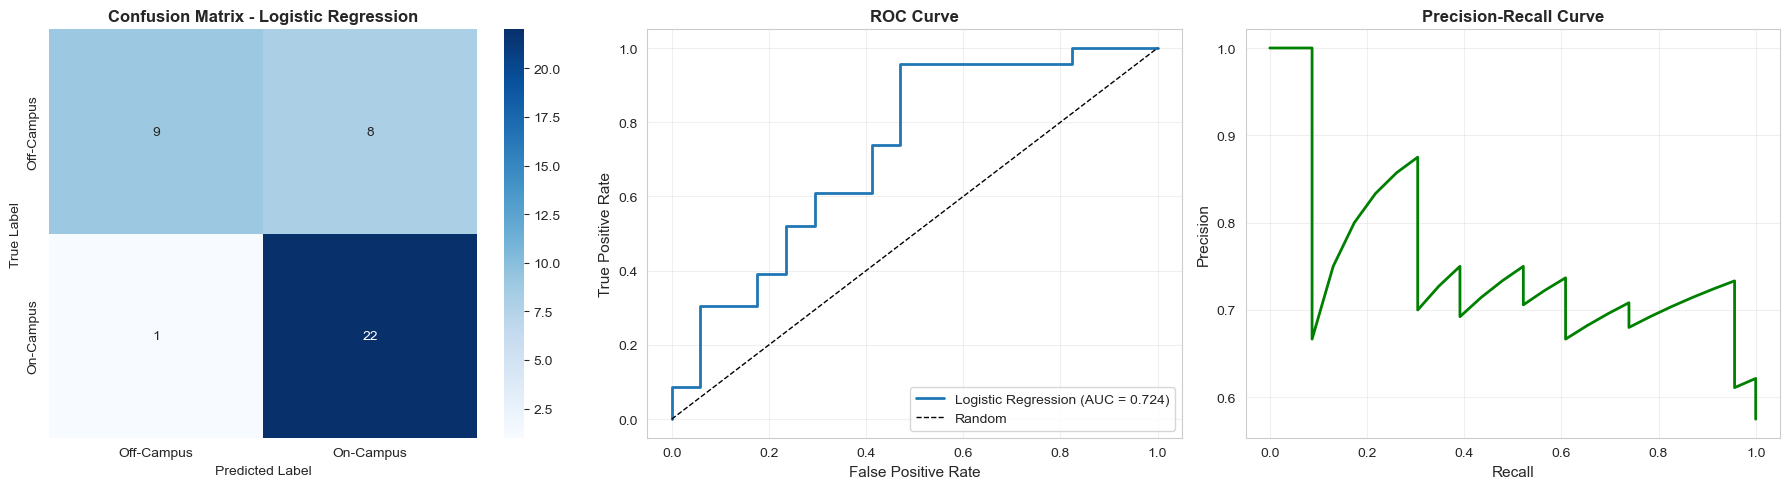

In [68]:
# Visualize logistic regression results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr_best)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Logistic Regression', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')
axes[0].set_xticklabels(['Off-Campus', 'On-Campus'])
axes[0].set_yticklabels(['Off-Campus', 'On-Campus'])

# 2. ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr_best)
axes[1].plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr_best:.3f})', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
axes[1].set_xlabel('False Positive Rate', fontsize=11)
axes[1].set_ylabel('True Positive Rate', fontsize=11)
axes[1].set_title('ROC Curve', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Precision-Recall Curve
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_proba_lr_best)
axes[2].plot(recall_lr, precision_lr, linewidth=2, color='green')
axes[2].set_xlabel('Recall', fontsize=11)
axes[2].set_ylabel('Precision', fontsize=11)
axes[2].set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 9. Random Forest Modeling <a id='section9'></a>

Random Forest advantages:
- Handles non-linear relationships
- No multicollinearity issues
- Provides feature importance
- Generally robust and accurate

In [69]:
print("=" * 80)
print("RANDOM FOREST MODELING")
print("=" * 80)

# Train basic Random Forest
print("\n" + "-" * 80)
print("Training Random Forest (Basic)")
print("-" * 80)

rf_basic = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    n_jobs=-1
)
rf_basic.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_basic.predict(X_test)
y_pred_proba_rf = rf_basic.predict_proba(X_test)[:, 1]

# Evaluate
accuracy_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print(f"\nTest Accuracy: {accuracy_rf:.4f}")
print(f"ROC AUC Score: {auc_rf:.4f}")

# Cross-validation
cv_scores_rf = cross_val_score(rf_basic, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std():.4f})")

print("\n" + "-" * 80)
print("Classification Report:")
print("-" * 80)
print(classification_report(y_test, y_pred_rf, target_names=['Off-Campus', 'On-Campus']))

RANDOM FOREST MODELING

--------------------------------------------------------------------------------
Training Random Forest (Basic)
--------------------------------------------------------------------------------

Test Accuracy: 0.8250
ROC AUC Score: 0.7596

Cross-Validation Accuracy: 0.7460 (+/- 0.0835)

--------------------------------------------------------------------------------
Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

  Off-Campus       0.86      0.71      0.77        17
   On-Campus       0.81      0.91      0.86        23

    accuracy                           0.82        40
   macro avg       0.83      0.81      0.82        40
weighted avg       0.83      0.82      0.82        40



In [70]:
# Hyperparameter tuning
print("\n" + "-" * 80)
print("Hyperparameter Tuning with Grid Search")
print("-" * 80)

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(n_jobs=-1),
    param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("\nPerforming grid search (this may take a few minutes)...")
grid_rf.fit(X_train, y_train)

print(f"\nBest parameters: {grid_rf.best_params_}")
print(f"Best CV score: {grid_rf.best_score_:.4f}")

# Best model
rf_best = grid_rf.best_estimator_
y_pred_rf_best = rf_best.predict(X_test)
y_pred_proba_rf_best = rf_best.predict_proba(X_test)[:, 1]

accuracy_rf_best = accuracy_score(y_test, y_pred_rf_best)
auc_rf_best = roc_auc_score(y_test, y_pred_proba_rf_best)

print(f"\nTest Accuracy: {accuracy_rf_best:.4f}")
print(f"ROC AUC Score: {auc_rf_best:.4f}")


--------------------------------------------------------------------------------
Hyperparameter Tuning with Grid Search
--------------------------------------------------------------------------------

Performing grid search (this may take a few minutes)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best CV score: 0.7716

Test Accuracy: 0.8250
ROC AUC Score: 0.7673



RANDOM FOREST FEATURE IMPORTANCE

Top 20 Most Important Features:
                                                                         Feature  Importance
                                                            delivered_items_etc.    0.055417
              order_reasons_transportation_issues_ex._limited_no_access_to_a_car    0.053837
                                                        store_preference_encoded    0.053077
                                                       packages_per_week_encoded    0.052381
                                      delivered_items_dormitory_goods_e.g._decor    0.035750
order_reasons_items_i_want_are_not_offered_by_on-campus_nearby_stores_or_vendors    0.035574
                                        delivered_items_gifted_items_from_family    0.028674
                                                         delivered_items_friends    0.028298
                                              most_delivered_cleaned_tfidf_goods    0.027178
   

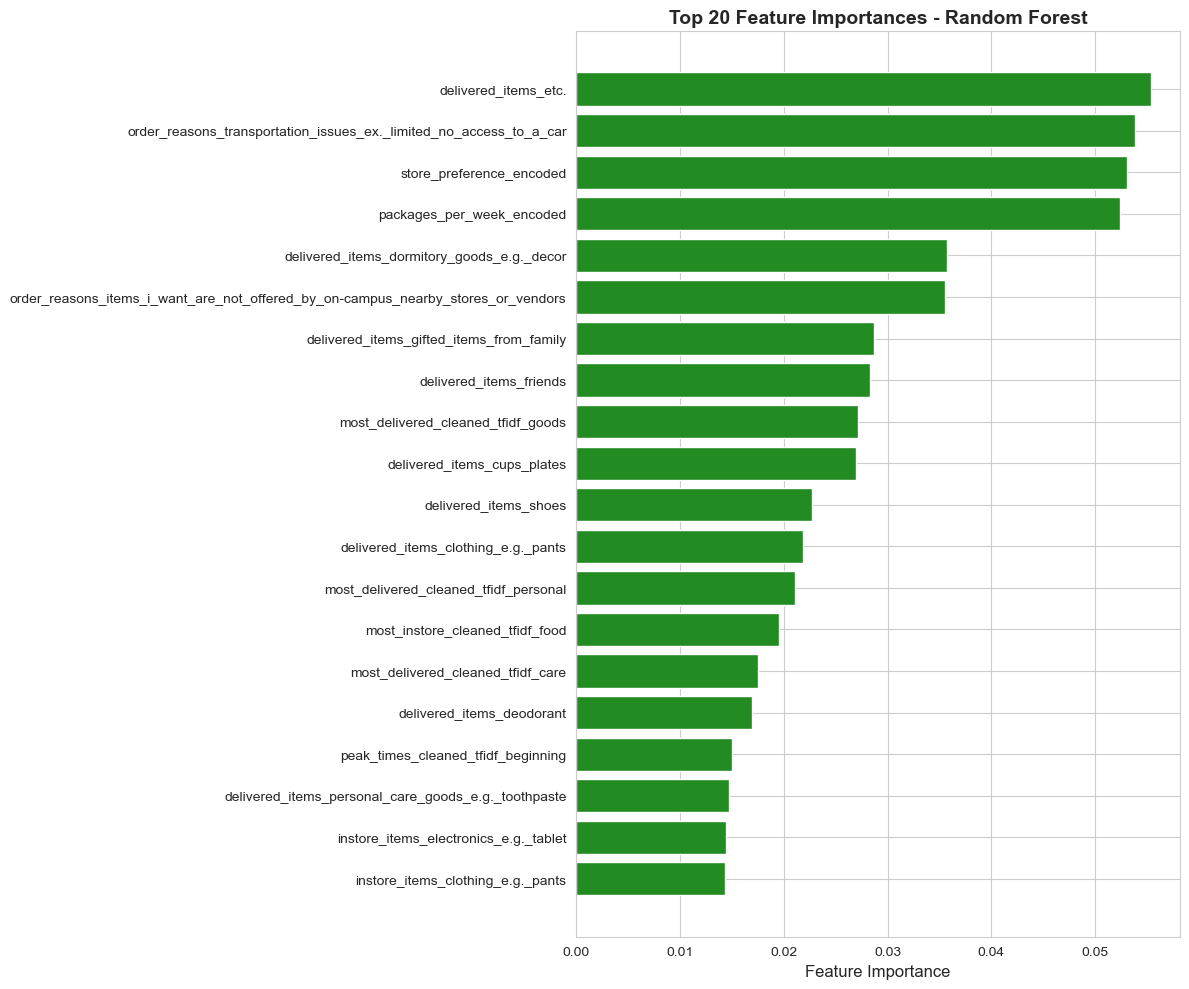

In [71]:
# Feature importance analysis
print("\n" + "=" * 80)
print("RANDOM FOREST FEATURE IMPORTANCE")
print("=" * 80)

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_best.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))

# Visualize
plt.figure(figsize=(12, 10))
top_20 = importance_df.head(20)
plt.barh(range(len(top_20)), top_20['Importance'], color='forestgreen')
plt.yticks(range(len(top_20)), top_20['Feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Top 20 Feature Importances - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

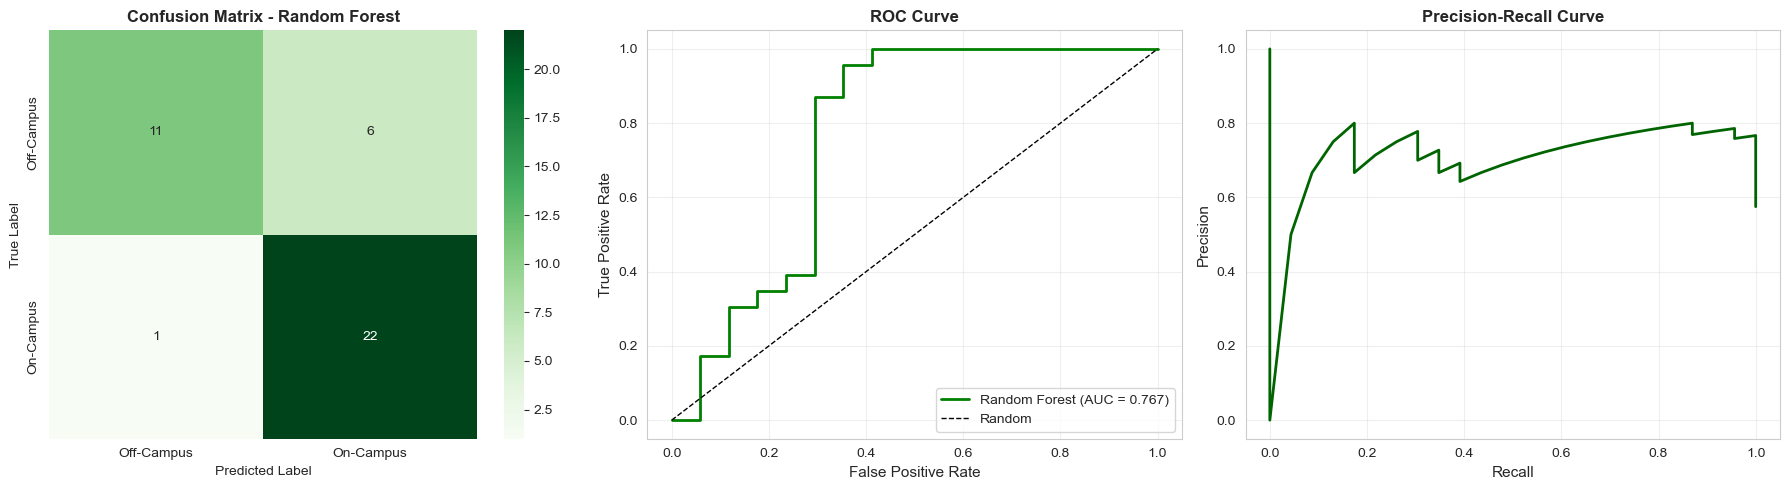

In [72]:
# Visualize Random Forest results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf_best)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[0])
axes[0].set_title('Confusion Matrix - Random Forest', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')
axes[0].set_xticklabels(['Off-Campus', 'On-Campus'])
axes[0].set_yticklabels(['Off-Campus', 'On-Campus'])

# 2. ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf_best)
axes[1].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf_best:.3f})', linewidth=2, color='green')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
axes[1].set_xlabel('False Positive Rate', fontsize=11)
axes[1].set_ylabel('True Positive Rate', fontsize=11)
axes[1].set_title('ROC Curve', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Precision-Recall Curve
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf_best)
axes[2].plot(recall_rf, precision_rf, linewidth=2, color='darkgreen')
axes[2].set_xlabel('Recall', fontsize=11)
axes[2].set_ylabel('Precision', fontsize=11)
axes[2].set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 10. Model Comparison and Conclusions <a id='section10'></a>

In [73]:
# Compare all models
print("=" * 80)
print("MODEL COMPARISON")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression (Basic)', 'Logistic Regression (Tuned)', 
              'Random Forest (Basic)', 'Random Forest (Tuned)'],
    'Test Accuracy': [accuracy_lr, accuracy_lr_best, accuracy_rf, accuracy_rf_best],
    'ROC AUC': [auc_lr, auc_lr_best, auc_rf, auc_rf_best],
    'CV Accuracy Mean': [cv_scores_lr.mean(), grid_lr.best_score_, 
                         cv_scores_rf.mean(), grid_rf.best_score_],
    'CV Accuracy Std': [cv_scores_lr.std(), np.nan, cv_scores_rf.std(), np.nan]
})

print("\n", comparison_df.to_string(index=False))

# Find best model
best_idx = comparison_df['Test Accuracy'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'Model']
best_accuracy = comparison_df.loc[best_idx, 'Test Accuracy']

print("\n" + "=" * 80)
print(f"BEST MODEL: {best_model_name}")
print(f"Test Accuracy: {best_accuracy:.4f}")
print("=" * 80)

MODEL COMPARISON

                       Model  Test Accuracy  ROC AUC  CV Accuracy Mean  CV Accuracy Std
Logistic Regression (Basic)          0.600 0.705882          0.669355         0.094022
Logistic Regression (Tuned)          0.775 0.723785          0.727218              NaN
      Random Forest (Basic)          0.825 0.759591          0.745968         0.083491
      Random Forest (Tuned)          0.825 0.767263          0.771573              NaN

BEST MODEL: Random Forest (Basic)
Test Accuracy: 0.8250


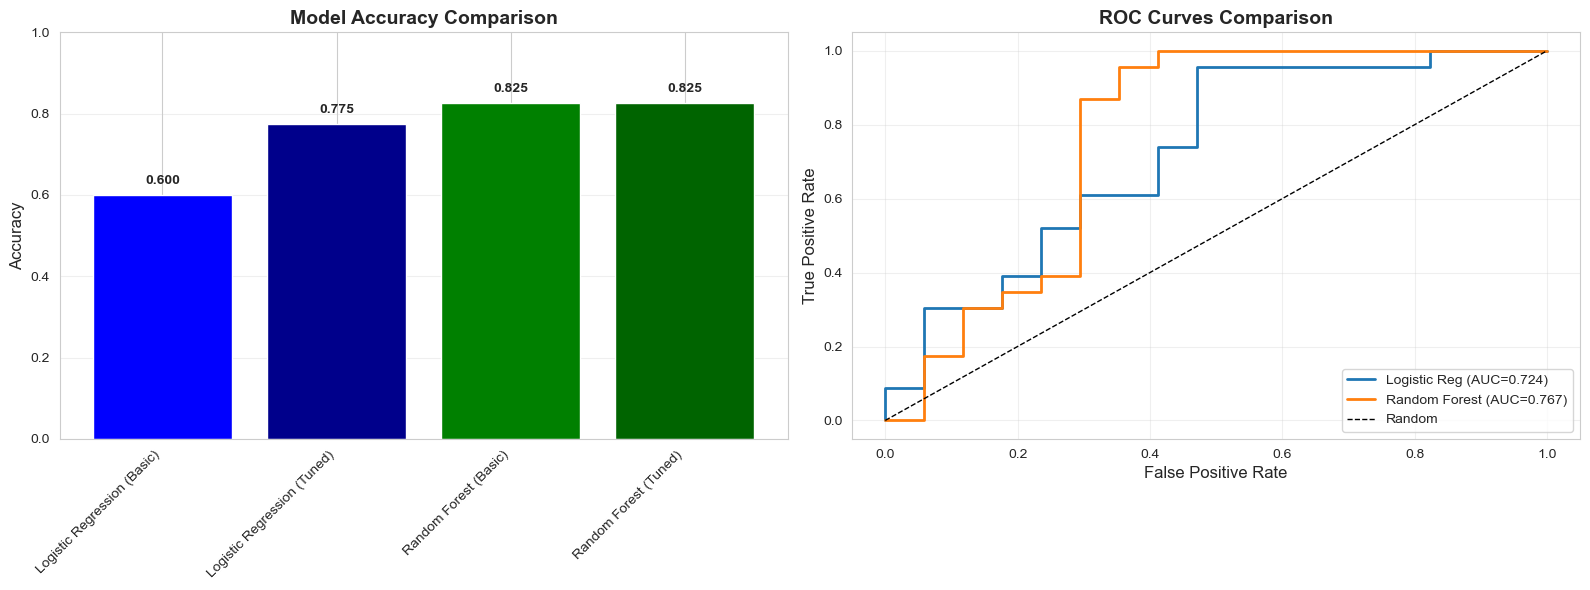

In [74]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Accuracy comparison
x_pos = np.arange(len(comparison_df))
axes[0].bar(x_pos, comparison_df['Test Accuracy'], color=['blue', 'darkblue', 'green', 'darkgreen'])
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, v in enumerate(comparison_df['Test Accuracy']):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. ROC curves comparison
axes[1].plot(fpr_lr, tpr_lr, label=f'Logistic Reg (AUC={auc_lr_best:.3f})', linewidth=2)
axes[1].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={auc_rf_best:.3f})', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [75]:
# Final conclusions
print("\n" + "="*80)
print("RESEARCH CONCLUSIONS")
print("="*80)

print("\n" + "-"*80)
print("Research Question:")
print("-"*80)
print("Can we predict student residency status based on shopping/delivery behaviors?")

print("\n" + "-"*80)
print("Answer: YES")
print("-"*80)

print(f"\nBest Model: {best_model_name}")
print(f"Prediction Accuracy: {best_accuracy:.1%}")
print(f"ROC AUC Score: {max(auc_lr_best, auc_rf_best):.3f}")

print("\n" + "-"*80)
print("Key Findings:")
print("-"*80)
print("\n1. PREDICTIVE POWER:")
print(f"   - We can predict residency with {best_accuracy:.1%} accuracy")
print("   - Shopping/delivery behaviors are strong indicators of housing status")

print("\n2. MOST IMPORTANT FACTORS:")
print("   Top predictors include:")
for i, row in importance_df.head(5).iterrows():
    print(f"   - {row['Feature']}")

print("\n3. MODEL INSIGHTS:")
if best_accuracy == accuracy_rf_best:
    print("   - Random Forest outperformed Logistic Regression")
    print("   - Non-linear relationships exist in the data")
    print("   - Feature interactions are important")
else:
    print("   - Logistic Regression performed best")
    print("   - Relationships are relatively linear")
    print("   - Model is interpretable through coefficients")



RESEARCH CONCLUSIONS

--------------------------------------------------------------------------------
Research Question:
--------------------------------------------------------------------------------
Can we predict student residency status based on shopping/delivery behaviors?

--------------------------------------------------------------------------------
Answer: YES
--------------------------------------------------------------------------------

Best Model: Random Forest (Basic)
Prediction Accuracy: 82.5%
ROC AUC Score: 0.767

--------------------------------------------------------------------------------
Key Findings:
--------------------------------------------------------------------------------

1. PREDICTIVE POWER:
   - We can predict residency with 82.5% accuracy
   - Shopping/delivery behaviors are strong indicators of housing status

2. MOST IMPORTANT FACTORS:
   Top predictors include:
   - delivered_items_etc.
   - order_reasons_transportation_issues_ex._limited_no_a

---
## 11. COMPREHENSIVE LOGISTIC REGRESSION ASSUMPTIONS CHECK <a id='section11'></a>

Now we'll systematically check **ALL** logistic regression assumptions before proper modeling.

In [76]:
print("=" * 80)
print("LOGISTIC REGRESSION ASSUMPTIONS - SYSTEMATIC CHECK")
print("=" * 80)

assumption_results = {}

# 1. Binary Outcome
print("\n1. BINARY OUTCOME")
print("-" * 80)
unique_values = y.unique()
print(f"Unique values in target: {unique_values}")
print(f"Target is binary: {len(unique_values) == 2}")
assumption_results['Binary Outcome'] = len(unique_values) == 2

# 2. Independence of Observations
print("\n2. INDEPENDENCE OF OBSERVATIONS")
print("-" * 80)
print("✓ Survey responses from different individuals")
print("✓ Each observation represents one student")
print("✓ No repeated measures or clustered data")
assumption_results['Independence'] = True

# 4. Binary Outcome Check (already done but confirm)
print("\n4. NO PERFECT SEPARATION")
print("-" * 80)
print("Will be checked during model fitting (convergence warnings)")
assumption_results['No Perfect Separation'] = 'Check model warnings'

print("\n" + "=" * 80)
print("SUMMARY OF BASIC ASSUMPTIONS")
print("=" * 80)
for assumption, status in assumption_results.items():
    status_str = "✓ PASS" if status == True else ("✗ FAIL" if status == False else str(status))
    print(f"{assumption:30s}: {status_str}")

LOGISTIC REGRESSION ASSUMPTIONS - SYSTEMATIC CHECK

1. BINARY OUTCOME
--------------------------------------------------------------------------------
Unique values in target: [1 0]
Target is binary: True

2. INDEPENDENCE OF OBSERVATIONS
--------------------------------------------------------------------------------
✓ Survey responses from different individuals
✓ Each observation represents one student
✓ No repeated measures or clustered data

4. NO PERFECT SEPARATION
--------------------------------------------------------------------------------
Will be checked during model fitting (convergence warnings)

SUMMARY OF BASIC ASSUMPTIONS
Binary Outcome                : ✓ PASS
Independence                  : ✓ PASS
No Perfect Separation         : Check model warnings


In [77]:
# ==============================================================================
# CHECK FOR OUTLIERS AND INFLUENTIAL POINTS
# ==============================================================================

print("\n" + "=" * 80)
print("5. CHECKING FOR EXTREME OUTLIERS (Cook's Distance & Leverage)")
print("=" * 80)

# Fit a logistic regression model to get diagnostic metrics
from statsmodels.discrete.discrete_model import Logit

# Use scaled features for logistic regression diagnostics
X_scaled_full = StandardScaler().fit_transform(X)
X_with_const = sm.add_constant(X_scaled_full)

# Fit statsmodels logistic regression
logit_model = Logit(y, X_with_const)

try:
    # Fit with reduced tolerance to avoid convergence issues
    logit_result = logit_model.fit(disp=0, maxiter=100)
    
    # Get influence measures
    influence = logit_result.get_influence()
    
    # Cook's Distance
    cooks_d = influence.cooks_distance[0]
    
    # Identify influential points (Cook's D > 1 or 4/n)
    threshold_1 = 1
    threshold_n = 4 / len(y)
    
    influential_1 = np.where(cooks_d > threshold_1)[0]
    influential_n = np.where(cooks_d > threshold_n)[0]
    
    print(f"\nCook's Distance Analysis:")
    print(f"  - Max Cook's D: {cooks_d.max():.4f}")
    print(f"  - Mean Cook's D: {cooks_d.mean():.4f}")
    print(f"  - Threshold (D > 1): {len(influential_1)} observations")
    print(f"  - Threshold (D > 4/n = {threshold_n:.4f}): {len(influential_n)} observations")
    
    # Visualize Cook's Distance
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Cook's D plot
    axes[0].stem(range(len(cooks_d)), cooks_d, markerfmt=',', basefmt=' ')
    axes[0].axhline(y=threshold_1, color='r', linestyle='--', label='D=1')
    axes[0].axhline(y=threshold_n, color='orange', linestyle='--', label=f'D=4/n')
    axes[0].set_xlabel('Observation Index')
    axes[0].set_ylabel("Cook's Distance")
    axes[0].set_title("Cook's Distance for All Observations", fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Box plot
    axes[1].boxplot(cooks_d, vert=True)
    axes[1].set_ylabel("Cook's Distance")
    axes[1].set_title("Cook's Distance Distribution", fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    if len(influential_1) == 0:
        print("\n✓ No extreme outliers detected (Cook's D < 1)")
        assumption_results['No Extreme Outliers'] = True
    else:
        print(f"\n⚠ {len(influential_1)} potential outliers detected (Cook's D > 1)")
        print(f"  Indices: {influential_1[:10]}...")  # Show first 10
        assumption_results['No Extreme Outliers'] = False
        
except Exception as e:
    print(f"\n⚠ Could not compute influence measures: {e}")
    print("Note: This may be due to perfect/near-perfect separation or convergence issues")
    assumption_results['No Extreme Outliers'] = 'Could not assess'


5. CHECKING FOR EXTREME OUTLIERS (Cook's Distance & Leverage)

⚠ Could not compute influence measures: Singular matrix
Note: This may be due to perfect/near-perfect separation or convergence issues



6. NO MULTICOLLINEARITY - COMPREHENSIVE VIF ANALYSIS

Calculating VIF for ALL features (this may take a moment)...

  Progress: 0/160 features processed...
  Progress: 20/160 features processed...
  Progress: 40/160 features processed...
  Progress: 60/160 features processed...
  Progress: 80/160 features processed...
  Progress: 100/160 features processed...
  Progress: 120/160 features processed...
  Progress: 140/160 features processed...

Completed VIF calculation for 160 features!

--------------------------------------------------------------------------------
VIF SUMMARY STATISTICS
--------------------------------------------------------------------------------
Mean VIF: inf
Median VIF: 9.20
Max VIF: inf
Min VIF: 0.00

VIF Categories:
  - Low (VIF < 5): 43 features (26.9%)
  - Moderate (5 <= VIF < 10): 41 features (25.6%)
  - High (VIF >= 10): 76 features (47.5%)
  - Infinite VIF: 40 features (perfect multicollinearity)

---------------------------------------------------------

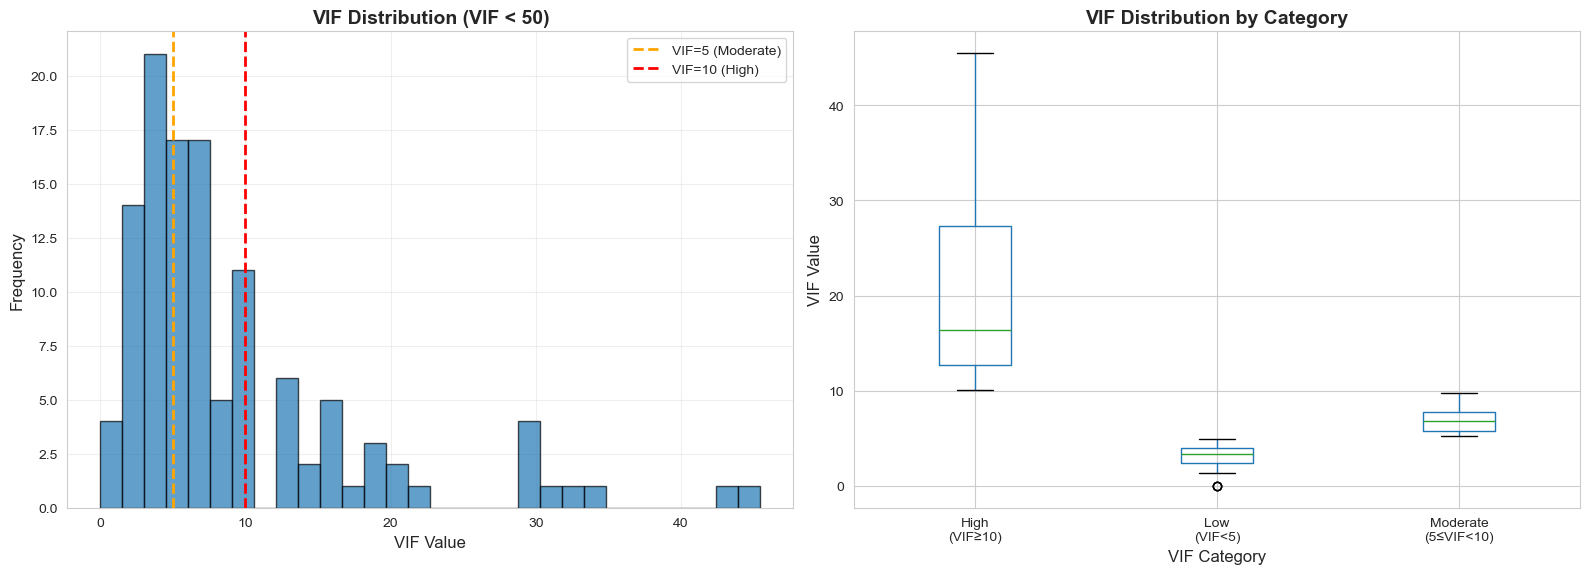

In [78]:
# ==============================================================================
# COMPREHENSIVE MULTICOLLINEARITY CHECK (VIF for ALL features)
# ==============================================================================

print("\n" + "=" * 80)
print("6. NO MULTICOLLINEARITY - COMPREHENSIVE VIF ANALYSIS")
print("=" * 80)

print("\nCalculating VIF for ALL features (this may take a moment)...\n")

# Calculate VIF for all features
vif_all = pd.DataFrame()
vif_all['Feature'] = X.columns

# Calculate VIF for each feature
vif_values = []
for i in range(len(X.columns)):
    if i % 20 == 0:  # Progress indicator
        print(f"  Progress: {i}/{len(X.columns)} features processed...")
    try:
        vif = variance_inflation_factor(X.values, i)
        vif_values.append(vif)
    except:
        vif_values.append(np.nan)

vif_all['VIF'] = vif_values
vif_all = vif_all.sort_values('VIF', ascending=False).reset_index(drop=True)

print(f"\nCompleted VIF calculation for {len(X.columns)} features!")

# Summary statistics
print("\n" + "-" * 80)
print("VIF SUMMARY STATISTICS")
print("-" * 80)
print(f"Mean VIF: {vif_all['VIF'].mean():.2f}")
print(f"Median VIF: {vif_all['VIF'].median():.2f}")
print(f"Max VIF: {vif_all['VIF'].max():.2f}")
print(f"Min VIF: {vif_all['VIF'].min():.2f}")

# Count by category
low_vif = len(vif_all[vif_all['VIF'] < 5])
moderate_vif = len(vif_all[(vif_all['VIF'] >= 5) & (vif_all['VIF'] < 10)])
high_vif = len(vif_all[vif_all['VIF'] >= 10])
inf_vif = len(vif_all[np.isinf(vif_all['VIF'])])

print(f"\nVIF Categories:")
print(f"  - Low (VIF < 5): {low_vif} features ({low_vif/len(vif_all)*100:.1f}%)")
print(f"  - Moderate (5 <= VIF < 10): {moderate_vif} features ({moderate_vif/len(vif_all)*100:.1f}%)")
print(f"  - High (VIF >= 10): {high_vif} features ({high_vif/len(vif_all)*100:.1f}%)")
if inf_vif > 0:
    print(f"  - Infinite VIF: {inf_vif} features (perfect multicollinearity)")

# Show top problematic features
print("\n" + "-" * 80)
print("TOP 20 FEATURES WITH HIGHEST VIF (Most Multicollinear)")
print("-" * 80)
print(vif_all.head(20).to_string(index=False))

# Identify features to remove
vif_threshold = 10
features_to_remove = vif_all[vif_all['VIF'] >= vif_threshold]['Feature'].tolist()

print(f"\n{'='*80}")
print(f"FEATURES WITH VIF >= {vif_threshold} (Problematic Multicollinearity)")
print(f"{'='*80}")
print(f"Number of features to consider removing: {len(features_to_remove)}")

if len(features_to_remove) > 0:
    print(f"\n⚠ High multicollinearity detected in {len(features_to_remove)} features")
    print("These features should be removed before logistic regression modeling")
    assumption_results['No Multicollinearity'] = False
else:
    print("\n✓ No severe multicollinearity detected (all VIF < 10)")
    assumption_results['No Multicollinearity'] = True

# Visualize VIF distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
vif_plot = vif_all[vif_all['VIF'] < 50]  # Exclude extreme values for better visualization
axes[0].hist(vif_plot['VIF'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(x=5, color='orange', linestyle='--', linewidth=2, label='VIF=5 (Moderate)')
axes[0].axvline(x=10, color='red', linestyle='--', linewidth=2, label='VIF=10 (High)')
axes[0].set_xlabel('VIF Value', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('VIF Distribution (VIF < 50)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot by category
categories = []
for vif in vif_all['VIF']:
    if vif < 5:
        categories.append('Low\n(VIF<5)')
    elif vif < 10:
        categories.append('Moderate\n(5≤VIF<10)')
    else:
        categories.append('High\n(VIF≥10)')

vif_all['Category'] = categories
vif_plot_box = vif_all[vif_all['VIF'] < 50]
vif_plot_box.boxplot(column='VIF', by='Category', ax=axes[1])
axes[1].set_xlabel('VIF Category', fontsize=12)
axes[1].set_ylabel('VIF Value', fontsize=12)
axes[1].set_title('VIF Distribution by Category', fontsize=14, fontweight='bold')
plt.suptitle('')  # Remove auto-generated title

plt.tight_layout()
plt.show()


7. LINEARITY IN THE LOGIT

Checking linearity assumption for continuous/numeric features...
Note: This assumption applies to continuous predictors, not binary/categorical ones

Testing linearity for 3 encoded numeric features
(Binary/one-hot features are excluded from this test)



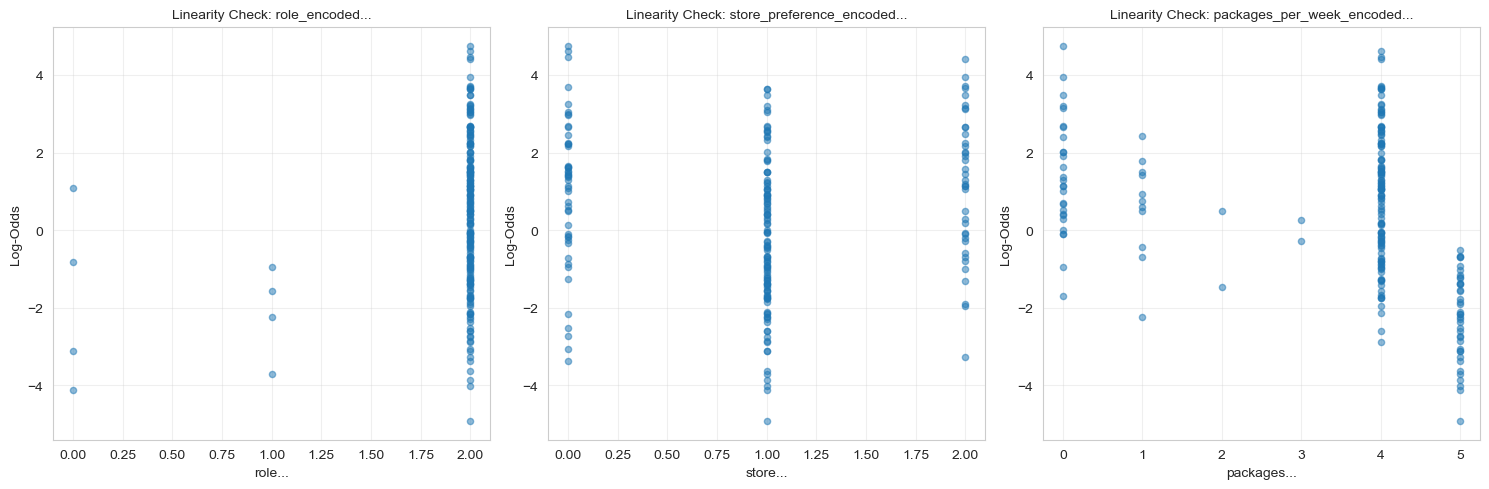


Interpretation:
- Linear pattern = assumption satisfied
- Non-linear pattern = consider transformations or non-linear models
✓ For binary/categorical features, this assumption is not applicable


In [79]:
# ==============================================================================
# LINEARITY IN THE LOGIT (Box-Tidwell Test)
# ==============================================================================

print("\n" + "=" * 80)
print("7. LINEARITY IN THE LOGIT")
print("=" * 80)

print("\nChecking linearity assumption for continuous/numeric features...")
print("Note: This assumption applies to continuous predictors, not binary/categorical ones\n")

# Select numeric features (excluding binary one-hot encoded features)
# Focus on features that are truly continuous/counts
numeric_features = [col for col in X.columns if '_encoded' in col]

if len(numeric_features) > 0:
    print(f"Testing linearity for {len(numeric_features)} encoded numeric features")
    print("(Binary/one-hot features are excluded from this test)\n")
    
    # Sample a few numeric features for visualization
    sample_features = numeric_features[:min(4, len(numeric_features))]
    
    # Visualize relationship with log-odds
    # Fit a model to get predicted probabilities
    lr_temp = LogisticRegression(max_iter=1000)
    lr_temp.fit(X_train, y_train)
    
    # Get predicted log-odds on full dataset
    # log-odds = log(p / (1-p))
    proba = lr_temp.predict_proba(X)[:, 1]
    # Avoid log(0) by clipping probabilities
    proba_clipped = np.clip(proba, 0.001, 0.999)
    log_odds = np.log(proba_clipped / (1 - proba_clipped))
    
    # Plot relationships
    fig, axes = plt.subplots(1, len(sample_features), figsize=(5*len(sample_features), 5))
    if len(sample_features) == 1:
        axes = [axes]
    
    for idx, feat in enumerate(sample_features):
        axes[idx].scatter(X[feat], log_odds, alpha=0.5, s=20)
        # Add smoothing line
        from scipy.interpolate import make_interp_spline
        try:
            # Sort data for smooth line
            x_sorted = np.sort(X[feat].values)
            y_sorted = log_odds[np.argsort(X[feat].values)]
            # Create smooth line (if enough unique points)
            if len(np.unique(x_sorted)) > 3:
                spl = make_interp_spline(x_sorted, y_sorted, k=min(3, len(np.unique(x_sorted))-1))
                x_smooth = np.linspace(x_sorted.min(), x_sorted.max(), 100)
                y_smooth = spl(x_smooth)
                axes[idx].plot(x_smooth, y_smooth, 'r-', linewidth=2, label='Smoothed')
        except:
            pass
        
        axes[idx].set_xlabel(feat.split('_')[0] + '...', fontsize=10)
        axes[idx].set_ylabel('Log-Odds', fontsize=10)
        axes[idx].set_title(f'Linearity Check: {feat[:30]}...', fontsize=10)
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nInterpretation:")
    print("- Linear pattern = assumption satisfied")
    print("- Non-linear pattern = consider transformations or non-linear models")
    print("✓ For binary/categorical features, this assumption is not applicable")
    assumption_results['Linearity in Logit'] = 'Visual inspection required'
else:
    print("No continuous numeric features found for linearity testing")
    print("✓ Most features are binary/categorical - linearity assumption not strictly applicable")
    assumption_results['Linearity in Logit'] = 'N/A - categorical features'

---
## 12. FEATURE SELECTION BASED ON VIF <a id='section12'></a>

Based on the multicollinearity analysis, we'll now remove high-VIF features and train models with the reduced feature set.

In [80]:
# ==============================================================================
# REMOVE HIGH VIF FEATURES
# ==============================================================================

print("=" * 80)
print("FEATURE SELECTION: Removing High-VIF Features")
print("=" * 80)

# Remove features with VIF >= 10
vif_threshold = 10
features_to_keep = vif_all[vif_all['VIF'] < vif_threshold]['Feature'].tolist()

print(f"\nVIF Threshold: {vif_threshold}")
print(f"Original number of features: {len(X.columns)}")
print(f"Features to remove (VIF >= {vif_threshold}): {len(features_to_remove)}")
print(f"Features to keep (VIF < {vif_threshold}): {len(features_to_keep)}")

# Create reduced feature set
X_reduced = X[features_to_keep].copy()

print(f"\nReduced feature set shape: {X_reduced.shape}")

n_events_reduced = min(y.sum(), len(y) - y.sum())



# Split the reduced dataset
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(
    X_reduced, y, test_size=0.2, stratify=y
)

print(f"\nReduced train set: {X_train_reduced.shape}")
print(f"Reduced test set: {X_test_reduced.shape}")

# Show which feature categories were most affected
print("\n" + "-" * 80)
print("Feature Types Removed:")
print("-" * 80)

removed_types = {}
for feat in features_to_remove:
    for keyword in ['delivered_items_', 'order_reasons_', 'instore_items_', 
                    'communication_methods_', 'shopping_interests_', '_tfidf_', '_encoded']:
        if keyword in feat:
            key = keyword.replace('_', ' ').strip()
            removed_types[key] = removed_types.get(key, 0) + 1
            break

for ftype, count in sorted(removed_types.items(), key=lambda x: x[1], reverse=True):
    print(f"  - {ftype}: {count} features")

print("\n" + "=" * 80)
print("FEATURE SELECTION COMPLETE")
print("=" * 80)

FEATURE SELECTION: Removing High-VIF Features

VIF Threshold: 10
Original number of features: 160
Features to remove (VIF >= 10): 76
Features to keep (VIF < 10): 84

Reduced feature set shape: (197, 84)

Reduced train set: (157, 84)
Reduced test set: (40, 84)

--------------------------------------------------------------------------------
Feature Types Removed:
--------------------------------------------------------------------------------
  - tfidf: 32 features
  - delivered items: 24 features
  - instore items: 16 features
  - shopping interests: 3 features
  - order reasons: 1 features

FEATURE SELECTION COMPLETE


LOGISTIC REGRESSION WITH VIF-SELECTED FEATURES

Training logistic regression with 84 features (reduced from 160)

Performing grid search for best regularization parameter...

Best C parameter: 0.1
Best CV score: 0.6940

--------------------------------------------------------------------------------
PERFORMANCE METRICS
--------------------------------------------------------------------------------
Test Accuracy: 0.7250
ROC AUC Score: 0.7263
CV Accuracy: 0.6940
CV Accuracy Mean: 0.6940 (+/- 0.0876)

--------------------------------------------------------------------------------
Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

  Off-Campus       0.75      0.53      0.62        17
   On-Campus       0.71      0.87      0.78        23

    accuracy                           0.72        40
   macro avg       0.73      0.70      0.70        40
weighted avg       0.73      0.72     

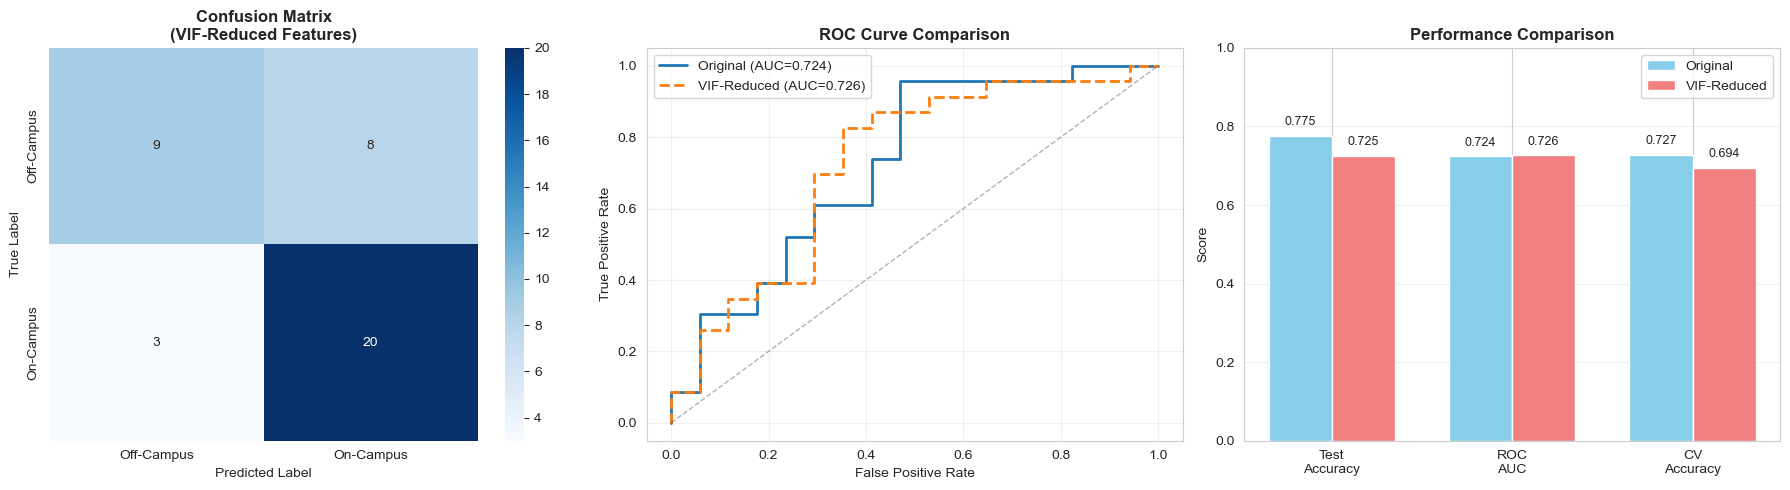

In [81]:
# ==============================================================================
# TRAIN LOGISTIC REGRESSION ON REDUCED FEATURES
# ==============================================================================

print("=" * 80)
print("LOGISTIC REGRESSION WITH VIF-SELECTED FEATURES")
print("=" * 80)

print(f"\nTraining logistic regression with {X_reduced.shape[1]} features (reduced from {X.shape[1]})")

# Train logistic regression with grid search
print("\nPerforming grid search for best regularization parameter...")

param_grid_reduced = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_lr_reduced = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid_reduced,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_lr_reduced.fit(X_train_reduced, y_train_reduced)

print(f"\nBest C parameter: {grid_lr_reduced.best_params_['C']}")
print(f"Best CV score: {grid_lr_reduced.best_score_:.4f}")

# Best model
lr_reduced = grid_lr_reduced.best_estimator_
y_pred_lr_reduced = lr_reduced.predict(X_test_reduced)
y_pred_proba_lr_reduced = lr_reduced.predict_proba(X_test_reduced)[:, 1]

# Evaluate
accuracy_lr_reduced = accuracy_score(y_test_reduced, y_pred_lr_reduced)
auc_lr_reduced = roc_auc_score(y_test_reduced, y_pred_proba_lr_reduced)

print(f"\n" + "-" * 80)
print("PERFORMANCE METRICS")
print("-" * 80)
print(f"Test Accuracy: {accuracy_lr_reduced:.4f}")
print(f"ROC AUC Score: {auc_lr_reduced:.4f}")
print(f"CV Accuracy: {grid_lr_reduced.best_score_:.4f}")

# Cross-validation scores
cv_scores_lr_reduced = cross_val_score(lr_reduced, X_train_reduced, y_train_reduced, cv=5, scoring='accuracy')
print(f"CV Accuracy Mean: {cv_scores_lr_reduced.mean():.4f} (+/- {cv_scores_lr_reduced.std():.4f})")

print("\n" + "-" * 80)
print("Classification Report:")
print("-" * 80)
print(classification_report(y_test_reduced, y_pred_lr_reduced, target_names=['Off-Campus', 'On-Campus']))

# Confusion matrix
print("\nConfusion Matrix:")
cm_lr_reduced = confusion_matrix(y_test_reduced, y_pred_lr_reduced)
print(cm_lr_reduced)

# Compare with original
print("\n" + "=" * 80)
print("COMPARISON: Original vs. VIF-Reduced Features")
print("=" * 80)
print(f"\n{'Metric':<25} {'Original':<15} {'VIF-Reduced':<15} {'Change':<15}")
print("-" * 70)
print(f"{'Number of Features':<25} {X.shape[1]:<15} {X_reduced.shape[1]:<15} {X_reduced.shape[1] - X.shape[1]:<15}")
print(f"{'Test Accuracy':<25} {accuracy_lr_best:<15.4f} {accuracy_lr_reduced:<15.4f} {accuracy_lr_reduced - accuracy_lr_best:<+15.4f}")
print(f"{'ROC AUC':<25} {auc_lr_best:<15.4f} {auc_lr_reduced:<15.4f} {auc_lr_reduced - auc_lr_best:<+15.4f}")
print(f"{'CV Accuracy':<25} {grid_lr.best_score_:<15.4f} {grid_lr_reduced.best_score_:<15.4f} {grid_lr_reduced.best_score_ - grid_lr.best_score_:<+15.4f}")

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Confusion matrix
sns.heatmap(cm_lr_reduced, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix\n(VIF-Reduced Features)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')
axes[0].set_xticklabels(['Off-Campus', 'On-Campus'])
axes[0].set_yticklabels(['Off-Campus', 'On-Campus'])

# ROC curves comparison
fpr_lr_reduced, tpr_lr_reduced, _ = roc_curve(y_test_reduced, y_pred_proba_lr_reduced)
axes[1].plot(fpr_lr, tpr_lr, label=f'Original (AUC={auc_lr_best:.3f})', linewidth=2)
axes[1].plot(fpr_lr_reduced, tpr_lr_reduced, label=f'VIF-Reduced (AUC={auc_lr_reduced:.3f})', linewidth=2, linestyle='--')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.3)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve Comparison', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Accuracy comparison
metrics = ['Test\nAccuracy', 'ROC\nAUC', 'CV\nAccuracy']
original_scores = [accuracy_lr_best, auc_lr_best, grid_lr.best_score_]
reduced_scores = [accuracy_lr_reduced, auc_lr_reduced, grid_lr_reduced.best_score_]

x = np.arange(len(metrics))
width = 0.35

axes[2].bar(x - width/2, original_scores, width, label='Original', color='skyblue')
axes[2].bar(x + width/2, reduced_scores, width, label='VIF-Reduced', color='lightcoral')
axes[2].set_ylabel('Score')
axes[2].set_title('Performance Comparison', fontsize=12, fontweight='bold')
axes[2].set_xticks(x)
axes[2].set_xticklabels(metrics)
axes[2].legend()
axes[2].set_ylim([0, 1])
axes[2].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (orig, red) in enumerate(zip(original_scores, reduced_scores)):
    axes[2].text(i - width/2, orig + 0.02, f'{orig:.3f}', ha='center', va='bottom', fontsize=9)
    axes[2].text(i + width/2, red + 0.02, f'{red:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

---
## 13. MODELING WITH PCA-TRANSFORMED FEATURES <a id='section13'></a>

Now we'll train models using PCA-transformed data to achieve similar or better accuracy with fewer features.

In [ ]:
# ==============================================================================
# PREPARE PCA-TRANSFORMED DATA
# ==============================================================================

print("=" * 80)
print("PCA-BASED MODELING")
print("=" * 80)

# We already have PCA fitted earlier, but let's prepare different component sizes
print("\nTesting multiple PCA configurations:")
print("  - 20 components (45% variance)")
print("  - 50 components (77% variance)")
print("  - 73 components (90% variance)")
print("  - Same number as VIF-reduced features")

# Standardize the data (already done earlier)
# X_scaled is already available from earlier PCA analysis

# Split standardized data
X_train_scaled, X_test_scaled, y_train_pca, y_test_pca = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y
)

# Different PCA configurations to test
pca_configs = [
    ('PCA-20', 20),
    ('PCA-50', 50),
    ('PCA-73', 73),
    (f'PCA-{X_reduced.shape[1]}', X_reduced.shape[1])  # Same as VIF-reduced
]

pca_results = []

for config_name, n_components in pca_configs:
    print(f"\n{'-' * 80}")
    print(f"Training with {config_name}")
    print(f"{'-' * 80}")
    
    # Fit PCA
    pca_model = PCA(n_components=n_components)
    X_train_pca = pca_model.fit_transform(X_train_scaled)
    X_test_pca = pca_model.transform(X_test_scaled)
    
    explained_var = pca_model.explained_variance_ratio_.sum()
    print(f"Number of components: {n_components}")
    print(f"Explained variance: {explained_var:.2%}")
    
    
    # Train logistic regression
    param_grid_pca = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
    grid_pca = GridSearchCV(
        LogisticRegression(max_iter=1000),
        param_grid_pca,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )
    
    grid_pca.fit(X_train_pca, y_train_pca)
    
    # Predictions
    lr_pca = grid_pca.best_estimator_
    y_pred_pca = lr_pca.predict(X_test_pca)
    y_pred_proba_pca = lr_pca.predict_proba(X_test_pca)[:, 1]
    
    # Evaluate
    accuracy_pca = accuracy_score(y_test_pca, y_pred_pca)
    auc_pca = roc_auc_score(y_test_pca, y_pred_proba_pca)
    cv_acc_pca = grid_pca.best_score_
    
    print(f"\nBest C: {grid_pca.best_params_['C']}")
    print(f"Test Accuracy: {accuracy_pca:.4f}")
    print(f"ROC AUC: {auc_pca:.4f}")
    print(f"CV Accuracy: {cv_acc_pca:.4f}")
    
    # Store results
    pca_results.append({
        'Name': config_name,
        'n_components': n_components,
        'explained_var': explained_var,
        'test_accuracy': accuracy_pca,
        'roc_auc': auc_pca,
        'cv_accuracy': cv_acc_pca,
        'best_C': grid_pca.best_params_['C'],
        'y_pred': y_pred_pca,
        'y_pred_proba': y_pred_proba_pca
    })

print("\n" + "=" * 80)
print("PCA MODELING COMPLETE")
print("=" * 80)

PCA-BASED MODELING

Testing multiple PCA configurations:
  - 20 components (45% variance)
  - 50 components (77% variance)
  - 73 components (90% variance)
  - Same number as VIF-reduced features

--------------------------------------------------------------------------------
Training with PCA-20
--------------------------------------------------------------------------------
Number of components: 20
Explained variance: 48.85%

Best C: 0.01
Test Accuracy: 0.7250
ROC AUC: 0.6931
CV Accuracy: 0.7014

--------------------------------------------------------------------------------
Training with PCA-50
--------------------------------------------------------------------------------
Number of components: 50
Explained variance: 82.09%

Best C: 0.01
Test Accuracy: 0.7000
ROC AUC: 0.7008
CV Accuracy: 0.6948

--------------------------------------------------------------------------------
Training with PCA-73
--------------------------------------------------------------------------------
Numb

---
## 14. COMPREHENSIVE MODEL COMPARISON <a id='section14'></a>

Now let's compare all models: Original, VIF-Reduced, and PCA variants.

COMPREHENSIVE MODEL COMPARISON

----------------------------------------------------------------------------------------------------
ALL MODELS COMPARISON
----------------------------------------------------------------------------------------------------
               Model  n_features  Test Accuracy  ROC AUC  CV Accuracy  Explained Var
   Original Features         160          0.775 0.723785     0.727218       1.000000
VIF-Reduced Features          84          0.725 0.726343     0.693952       1.000000
              PCA-20          20          0.725 0.693095     0.701411       0.488538
              PCA-50          50          0.700 0.700767     0.694758       0.820894
              PCA-73          73          0.650 0.685422     0.701613       0.938364
              PCA-84          84          0.675 0.682864     0.701613       0.968674

BEST MODELS
Best Test Accuracy: Original Features (0.7750)
Best ROC AUC: VIF-Reduced Features (0.7263)
Best CV Accuracy: Original Features (0.7272)


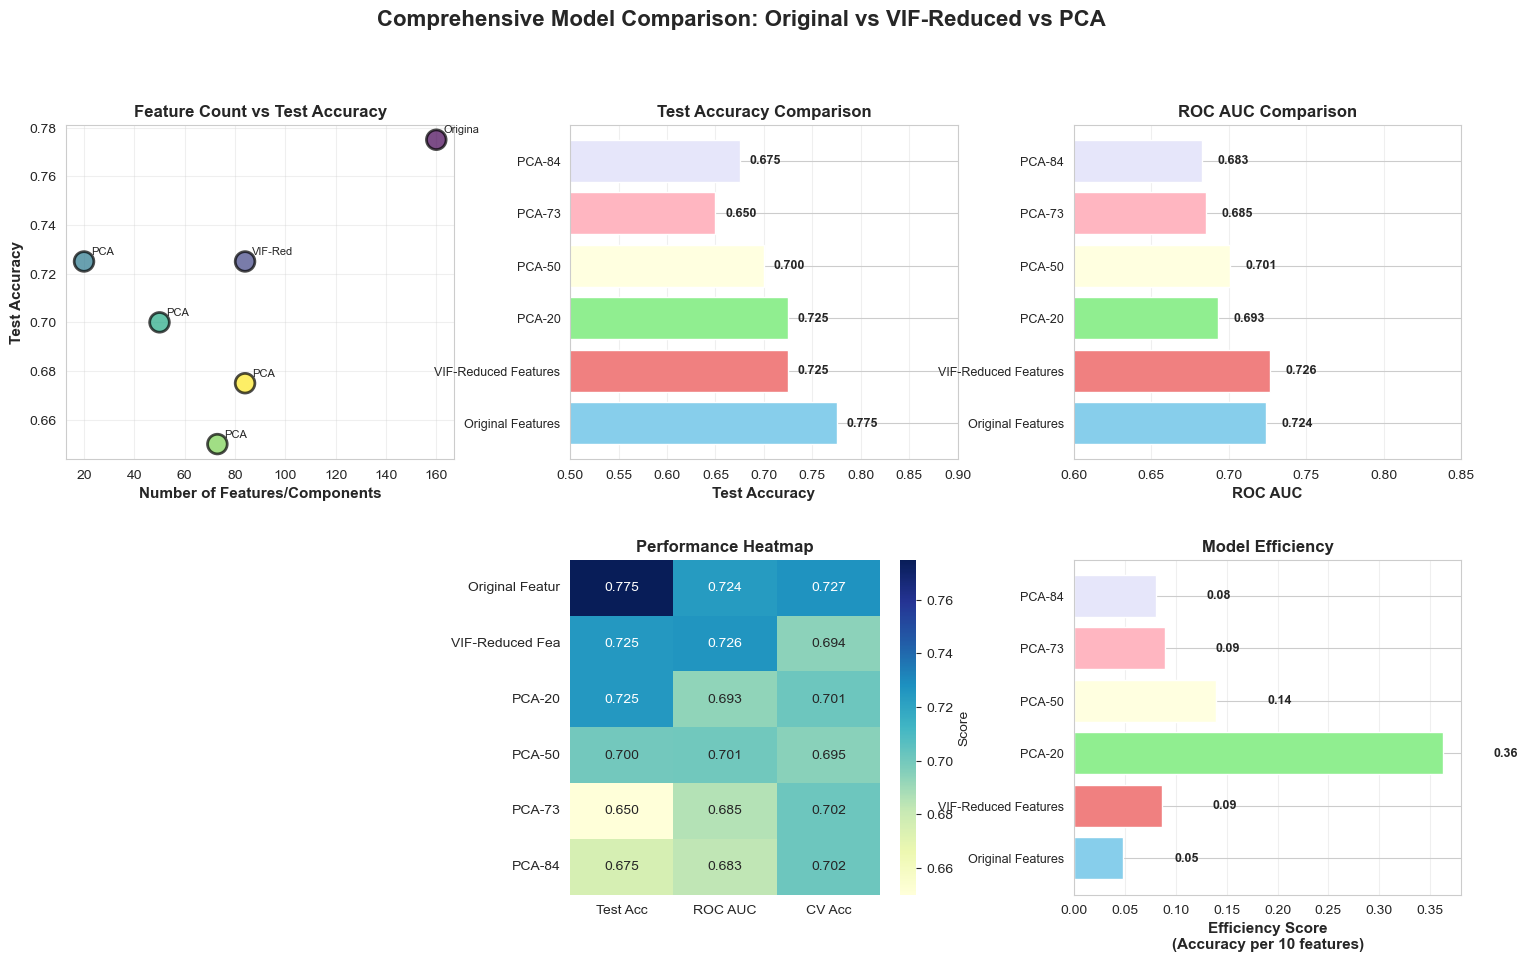


KEY INSIGHTS

1. FEATURE REDUCTION IMPACT:
   - Original: 160 features → 0.775 accuracy
   - VIF-Reduced: 84 features → 0.725 accuracy
   - Feature reduction: 47.5%
   - Accuracy change: -5.0%

2. PCA PERFORMANCE:
   - Best PCA: PCA-20 with 20 components
   - Accuracy: 0.725
   - Explained variance: 48.9%
   - Can achieve 72.5% accuracy with 12% fewer features

3. MOST EFFICIENT MODEL:
   - PCA-20
   - Features: 20
   - Accuracy: 0.725

4. RECOMMENDATION:
   ✓ Use PCA-20 for best balance of:
     - Performance (72.5% accuracy)
     - Interpretability (fewer features)



In [83]:
# ==============================================================================
# COMPREHENSIVE COMPARISON: ALL MODELS
# ==============================================================================

print("=" * 80)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 80)

# Create comparison dataframe
comparison_all = pd.DataFrame({
    'Model': ['Original Features', 'VIF-Reduced Features'] + [r['Name'] for r in pca_results],
    'n_features': [X.shape[1], X_reduced.shape[1]] + [r['n_components'] for r in pca_results],
    'Test Accuracy': [accuracy_lr_best, accuracy_lr_reduced] + [r['test_accuracy'] for r in pca_results],
    'ROC AUC': [auc_lr_best, auc_lr_reduced] + [r['roc_auc'] for r in pca_results],
    'CV Accuracy': [grid_lr.best_score_, grid_lr_reduced.best_score_] + [r['cv_accuracy'] for r in pca_results],
})

# Add explained variance for PCA models
comparison_all['Explained Var'] = [1.0, 1.0] + [r['explained_var'] for r in pca_results]

print("\n" + "-" * 100)
print("ALL MODELS COMPARISON")
print("-" * 100)
print(comparison_all.to_string(index=False))

# Find best models
best_accuracy_idx = comparison_all['Test Accuracy'].idxmax()
best_auc_idx = comparison_all['ROC AUC'].idxmax()
best_cv_idx = comparison_all['CV Accuracy'].idxmax()

print("\n" + "=" * 80)
print("BEST MODELS")
print("=" * 80)
print(f"Best Test Accuracy: {comparison_all.loc[best_accuracy_idx, 'Model']} ({comparison_all.loc[best_accuracy_idx, 'Test Accuracy']:.4f})")
print(f"Best ROC AUC: {comparison_all.loc[best_auc_idx, 'Model']} ({comparison_all.loc[best_auc_idx, 'ROC AUC']:.4f})")
print(f"Best CV Accuracy: {comparison_all.loc[best_cv_idx, 'Model']} ({comparison_all.loc[best_cv_idx, 'CV Accuracy']:.4f})")

# Visualize comprehensive comparison
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. Feature Count vs Accuracy
ax1 = fig.add_subplot(gs[0, 0])
scatter = ax1.scatter(comparison_all['n_features'], comparison_all['Test Accuracy'], 
                      s=200, c=comparison_all.index, cmap='viridis', alpha=0.7, edgecolors='black', linewidth=2)
for idx, row in comparison_all.iterrows():
    ax1.annotate(row['Model'].split('-')[0] if 'PCA' in row['Model'] else row['Model'].split()[0][:7], 
                 (row['n_features'], row['Test Accuracy']), 
                 xytext=(5, 5), textcoords='offset points', fontsize=8)
ax1.set_xlabel('Number of Features/Components', fontsize=11, fontweight='bold')
ax1.set_ylabel('Test Accuracy', fontsize=11, fontweight='bold')
ax1.set_title('Feature Count vs Test Accuracy', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# 2. Accuracy Comparison Bar Plot
ax2 = fig.add_subplot(gs[0, 1])
colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightyellow', 'lightpink', 'lavender']
bars = ax2.barh(range(len(comparison_all)), comparison_all['Test Accuracy'], color=colors[:len(comparison_all)])
ax2.set_yticks(range(len(comparison_all)))
ax2.set_yticklabels(comparison_all['Model'], fontsize=9)
ax2.set_xlabel('Test Accuracy', fontsize=11, fontweight='bold')
ax2.set_title('Test Accuracy Comparison', fontsize=12, fontweight='bold')
ax2.set_xlim([0.5, 0.9])
# Add value labels
for i, (idx, row) in enumerate(comparison_all.iterrows()):
    ax2.text(row['Test Accuracy'] + 0.01, i, f"{row['Test Accuracy']:.3f}", 
             va='center', fontsize=9, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# 3. ROC AUC Comparison
ax3 = fig.add_subplot(gs[0, 2])
ax3.barh(range(len(comparison_all)), comparison_all['ROC AUC'], color=colors[:len(comparison_all)])
ax3.set_yticks(range(len(comparison_all)))
ax3.set_yticklabels(comparison_all['Model'], fontsize=9)
ax3.set_xlabel('ROC AUC', fontsize=11, fontweight='bold')
ax3.set_title('ROC AUC Comparison', fontsize=12, fontweight='bold')
ax3.set_xlim([0.6, 0.85])
# Add value labels
for i, (idx, row) in enumerate(comparison_all.iterrows()):
    ax3.text(row['ROC AUC'] + 0.01, i, f"{row['ROC AUC']:.3f}", 
             va='center', fontsize=9, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# 5. All Metrics Heatmap
ax5 = fig.add_subplot(gs[1, 1])
metrics_normalized = comparison_all[['Test Accuracy', 'ROC AUC', 'CV Accuracy']].values
sns.heatmap(metrics_normalized, annot=True, fmt='.3f', cmap='YlGnBu', 
            xticklabels=['Test Acc', 'ROC AUC', 'CV Acc'],
            yticklabels=comparison_all['Model'].str[:15], ax=ax5, cbar_kws={'label': 'Score'})
ax5.set_title('Performance Heatmap', fontsize=12, fontweight='bold')

# 6. Efficiency Plot (Accuracy vs Features)
ax6 = fig.add_subplot(gs[1, 2])
efficiency = comparison_all['Test Accuracy'] / (comparison_all['n_features'] / 10)  # Normalize by 10 features
ax6.barh(range(len(comparison_all)), efficiency, color=colors[:len(comparison_all)])
ax6.set_yticks(range(len(comparison_all)))
ax6.set_yticklabels(comparison_all['Model'], fontsize=9)
ax6.set_xlabel('Efficiency Score\n(Accuracy per 10 features)', fontsize=11, fontweight='bold')
ax6.set_title('Model Efficiency', fontsize=12, fontweight='bold')
# Add value labels
for i, eff in enumerate(efficiency):
    ax6.text(eff + 0.05, i, f"{eff:.2f}", va='center', fontsize=9, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='x')

plt.suptitle('Comprehensive Model Comparison: Original vs VIF-Reduced vs PCA', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("KEY INSIGHTS")
print("=" * 80)

# Find most efficient model (good accuracy with fewer features)
comparison_all['Efficiency'] = comparison_all['Test Accuracy'] / np.sqrt(comparison_all['n_features'])
best_efficiency_idx = comparison_all['Efficiency'].idxmax()

print(f"\n1. FEATURE REDUCTION IMPACT:")
print(f"   - Original: {X.shape[1]} features → {accuracy_lr_best:.3f} accuracy")
print(f"   - VIF-Reduced: {X_reduced.shape[1]} features → {accuracy_lr_reduced:.3f} accuracy")
print(f"   - Feature reduction: {(1 - X_reduced.shape[1]/X.shape[1])*100:.1f}%")
print(f"   - Accuracy change: {(accuracy_lr_reduced - accuracy_lr_best)*100:+.1f}%")

print(f"\n2. PCA PERFORMANCE:")
best_pca = max(pca_results, key=lambda x: x['test_accuracy'])
print(f"   - Best PCA: {best_pca['Name']} with {best_pca['n_components']} components")
print(f"   - Accuracy: {best_pca['test_accuracy']:.3f}")
print(f"   - Explained variance: {best_pca['explained_var']:.1%}")
print(f"   - Can achieve {best_pca['test_accuracy']:.1%} accuracy with {(best_pca['n_components']/X.shape[1])*100:.0f}% fewer features")

print(f"\n3. MOST EFFICIENT MODEL:")
print(f"   - {comparison_all.loc[best_efficiency_idx, 'Model']}")
print(f"   - Features: {comparison_all.loc[best_efficiency_idx, 'n_features']}")
print(f"   - Accuracy: {comparison_all.loc[best_efficiency_idx, 'Test Accuracy']:.3f}")

print(f"\n4. RECOMMENDATION:")
print(f"   ✓ Use {comparison_all.loc[best_efficiency_idx, 'Model']} for best balance of:")
print(f"     - Performance ({comparison_all.loc[best_efficiency_idx, 'Test Accuracy']:.1%} accuracy)")
print(f"     - Interpretability (fewer features)")

print("\n" + "=" * 80)

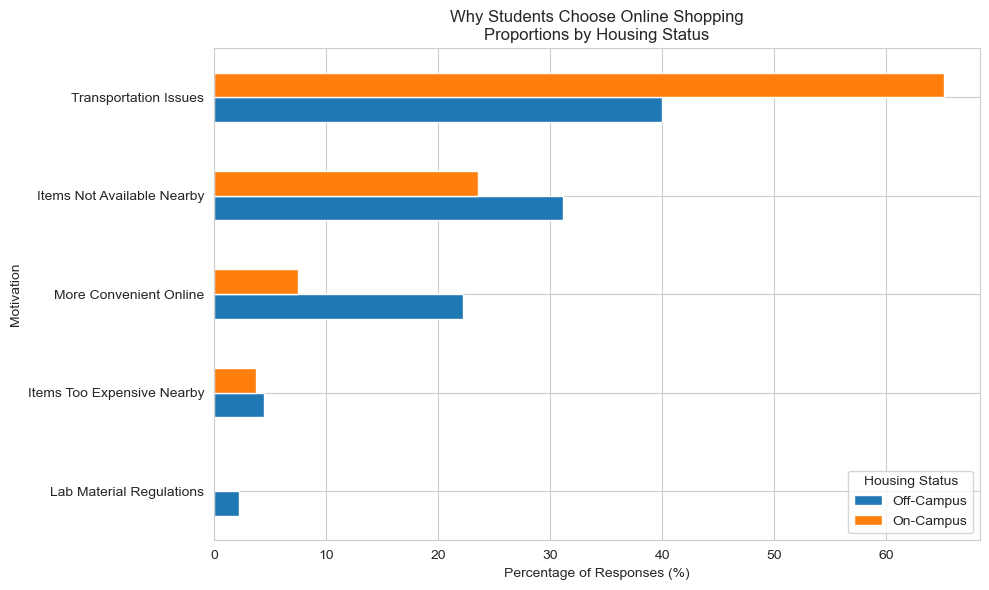

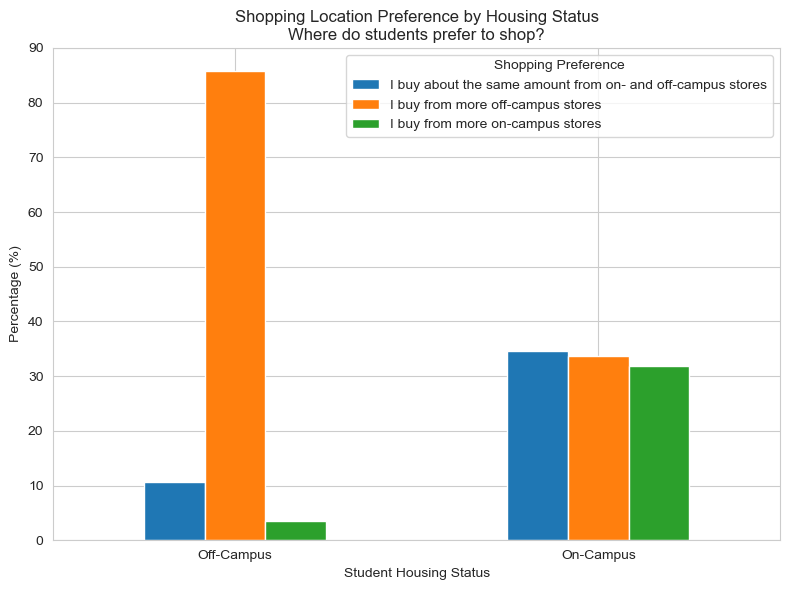

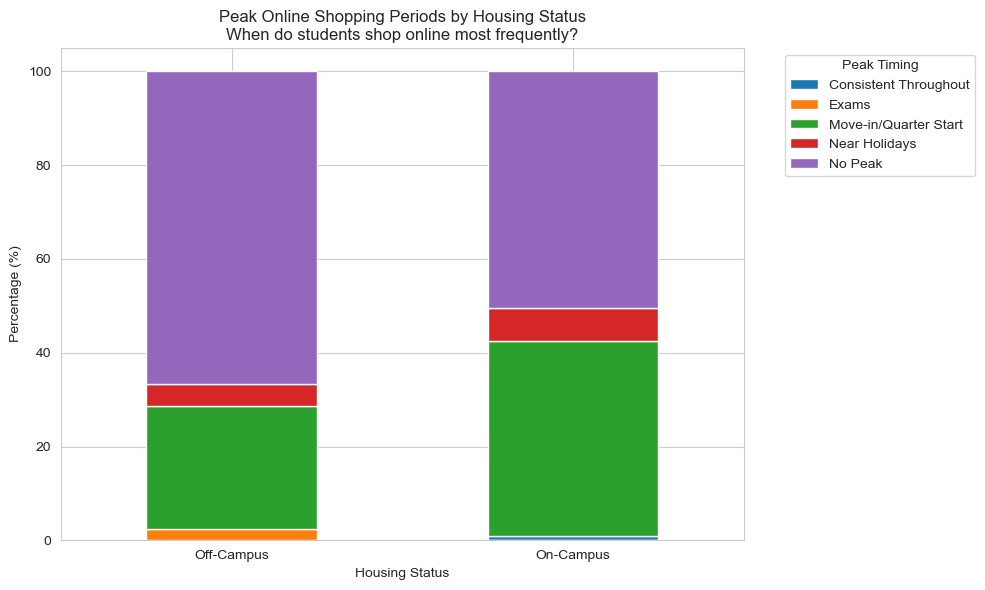

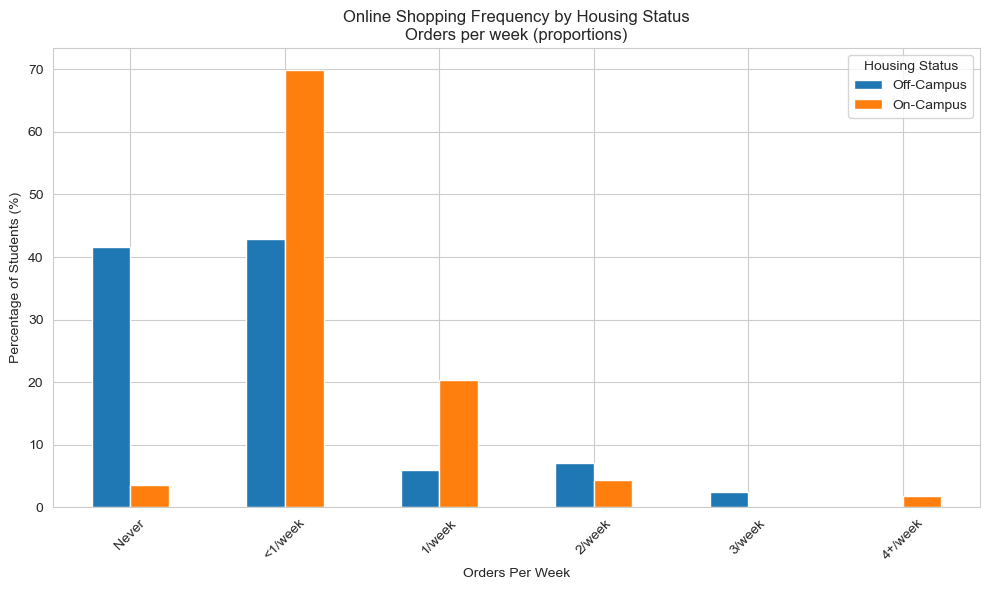

In [88]:
# Load required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
shopping = pd.read_csv("data.csv")

# Rename columns for easier access
shopping.columns = [
    'timestamp', 'student_status', 'housing', 'primary_access', 'orders_per_week',
    'items_per_order', 'cardboard_disposal', 'plastic_disposal', 'item_types',
    'most_delivered_items', 'peak_package_freq', 'why_deliver', 'instore_items',
    'most_instore_items', 'on_off_campus', 'shopping_options', 'items_wanted',
    'news_source', 'other_comments'
]

# Shopping motivation proportions by housing status
def classify_housing(housing):
    if pd.isna(housing):
        return "Other"
    housing_str = str(housing).lower()
    if "on-campus" in housing_str or "on campus" in housing_str:
        return "On-Campus"
    elif "off-campus" in housing_str or "off campus" in housing_str:
        return "Off-Campus"
    else:
        return "Other"

def classify_delivery_reason(why_deliver):
    if pd.isna(why_deliver) or why_deliver == "NA":
        return None
    reason_str = str(why_deliver).lower()
    if "transportation" in reason_str:
        return "Transportation Issues"
    elif "not offered" in reason_str:
        return "Items Not Available Nearby"
    elif "too expensive" in reason_str:
        return "Items Too Expensive Nearby"
    elif "convenient" in reason_str:
        return "More Convenient Online"
    elif "lab materials" in reason_str:
        return "Lab Material Regulations"
    elif "shipping is free" in reason_str or "free shipping" in reason_str:
        return "Free Shipping"
    elif "discount" in reason_str:
        return "Online Discount"
    else:
        return why_deliver

online_reasons = shopping.copy()
online_reasons['housing_simple'] = online_reasons['housing'].apply(classify_housing)
online_reasons['why_deliver_short'] = online_reasons['why_deliver'].apply(classify_delivery_reason)
online_reasons = online_reasons[online_reasons['why_deliver_short'].notna()]

online_reasons_grouped = online_reasons.groupby(['housing_simple', 'why_deliver_short']).size().reset_index(name='count')
online_reasons_grouped['proportion'] = online_reasons_grouped.groupby('housing_simple')['count'].transform(lambda x: x / x.sum())
online_reasons_grouped['percentage'] = online_reasons_grouped['proportion'] * 100

# Plot 1: Why Students Choose Online Shopping
fig, ax = plt.subplots(figsize=(10, 6))
pivot_data = online_reasons_grouped.pivot(index='why_deliver_short', columns='housing_simple', values='percentage')
if not pivot_data.empty:
    pivot_data = pivot_data.fillna(0)
    # Sort by average percentage across all housing types
    pivot_data['avg'] = pivot_data.mean(axis=1)
    pivot_data = pivot_data.sort_values('avg', ascending=True).drop('avg', axis=1)
    pivot_data.plot(kind='barh', ax=ax, figsize=(10, 6))
    plt.title("Why Students Choose Online Shopping\nProportions by Housing Status")
    plt.xlabel("Percentage of Responses (%)")
    plt.ylabel("Motivation")
    plt.legend(title="Housing Status")
    plt.tight_layout()
plt.show()

# Shopping preferences by housing status
shopping_location = shopping.copy()
shopping_location['housing_simple'] = shopping_location['housing'].apply(classify_housing)
shopping_location_grouped = shopping_location.groupby(['housing_simple', 'on_off_campus']).size().reset_index(name='count')
shopping_location_grouped['proportion'] = shopping_location_grouped.groupby('housing_simple')['count'].transform(lambda x: x / x.sum())
shopping_location_grouped['percentage'] = shopping_location_grouped['proportion'] * 100

# Plot 2: Shopping Location Preference
fig, ax = plt.subplots(figsize=(8, 6))
pivot_location = shopping_location_grouped.pivot(index='housing_simple', columns='on_off_campus', values='percentage')
if not pivot_location.empty:
    pivot_location = pivot_location.fillna(0)
    pivot_location.plot(kind='bar', ax=ax, figsize=(8, 6))
    plt.title("Shopping Location Preference by Housing Status\nWhere do students prefer to shop?")
    plt.xlabel("Student Housing Status")
    plt.ylabel("Percentage (%)")
    plt.legend(title="Shopping Preference")
    plt.xticks(rotation=0)
    plt.tight_layout()
plt.show()

# Peak shopping times
def classify_peak_time(peak_package_freq):
    if pd.isna(peak_package_freq):
        return "No Peak"
    peak_lower = str(peak_package_freq).lower()
    if any(word in peak_lower for word in ["move", "quarter", "beginning", "start"]):
        return "Move-in/Quarter Start"
    elif any(word in peak_lower for word in ["holiday", "christmas", "december"]):
        return "Near Holidays"
    elif peak_lower in ["no", "nope", "none", "not really", "not necessarily"]:
        return "No Peak"
    elif any(word in peak_lower for word in ["exam", "midterm"]):
        return "Exams"
    elif "consistent" in peak_lower:
        return "Consistent Throughout"
    else:
        return "No Peak"

peak_times = shopping.copy()
peak_times['housing_simple'] = peak_times['housing'].apply(classify_housing)
peak_times['peak_short'] = peak_times['peak_package_freq'].apply(classify_peak_time)
peak_times_grouped = peak_times.groupby(['housing_simple', 'peak_short']).size().reset_index(name='count')
peak_times_grouped['proportion'] = peak_times_grouped.groupby('housing_simple')['count'].transform(lambda x: x / x.sum())
peak_times_grouped['percentage'] = peak_times_grouped['proportion'] * 100

# Plot 3: Peak Shopping Periods
fig, ax = plt.subplots(figsize=(10, 6))
pivot_peak = peak_times_grouped.pivot(index='housing_simple', columns='peak_short', values='percentage')
if not pivot_peak.empty:
    pivot_peak = pivot_peak.fillna(0)
    pivot_peak.plot(kind='bar', stacked=True, ax=ax, figsize=(10, 6))
    plt.title("Peak Online Shopping Periods by Housing Status\nWhen do students shop online most frequently?")
    plt.xlabel("Housing Status")
    plt.ylabel("Percentage (%)")
    plt.legend(title="Peak Timing", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=0)
    plt.tight_layout()
plt.show()

# Order frequency by housing status
def classify_order_freq(orders_per_week):
    if pd.isna(orders_per_week):
        return "Unknown"
    order_str = str(orders_per_week).lower()
    if "never" in order_str:
        return "Never"
    elif "<1" in order_str or "less than 1" in order_str:
        return "<1/week"
    elif order_str == "1" or "1 package" in order_str:
        return "1/week"
    elif order_str == "2" or "2 packages" in order_str:
        return "2/week"
    elif order_str == "3" or "3 packages" in order_str:
        return "3/week"
    elif "4" in order_str or "more than 3" in order_str:
        return "4+/week"
    else:
        return order_str

order_freq = shopping.copy()
order_freq['housing_simple'] = order_freq['housing'].apply(classify_housing)
order_freq['orders_short'] = order_freq['orders_per_week'].apply(classify_order_freq)
order_freq_grouped = order_freq.groupby(['housing_simple', 'orders_short']).size().reset_index(name='count')
order_freq_grouped['proportion'] = order_freq_grouped.groupby('housing_simple')['count'].transform(lambda x: x / x.sum())
order_freq_grouped['percentage'] = order_freq_grouped['proportion'] * 100

# Plot 4: Shopping Frequency
fig, ax = plt.subplots(figsize=(10, 6))
pivot_freq = order_freq_grouped.pivot(index='orders_short', columns='housing_simple', values='percentage')
if not pivot_freq.empty:
    pivot_freq = pivot_freq.fillna(0)
    # Reorder to logical order
    order_mapping = {"Never": 0, "<1/week": 1, "1/week": 2, "2/week": 3, "3/week": 4, "4+/week": 5}
    pivot_freq['sort_key'] = pivot_freq.index.map(lambda x: order_mapping.get(x, 99))
    pivot_freq = pivot_freq.sort_values('sort_key').drop('sort_key', axis=1)
    pivot_freq.plot(kind='bar', ax=ax, figsize=(10, 6))
    plt.title("Online Shopping Frequency by Housing Status\nOrders per week (proportions)")
    plt.xlabel("Orders Per Week")
    plt.ylabel("Percentage of Students (%)")
    plt.legend(title="Housing Status")
    plt.xticks(rotation=45)
    plt.tight_layout()
plt.show()